In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("/kaggle/input/mimic-ards/mlhc-ards-cohort-data.csv")

X_cont = df[['max_norepinephrine_equiv', 'avg_norepinephrine_equiv', 'sofa_cardiovascular_avg_meanbp','sofa_cardiovascular_avg_rate_norepinephrine', 'sofa_respiration_avg_pao2fio2ratio', 'sofa_renal_avg_urineoutput', 'sofa_renal_avg_creatinine', 'sofa_cns_avg_gcs', 'first24hr_cardiovascular_rate_norepinephrine', 'first24hr_cardiovascular_meanbp', 'first24hr_respiration_pao2fio2ratio', 'first24hr_renal_urineoutput','first24hr_renal_creatinine', 'first24hr_cns_gcs', 'sofa_cardiovascular_worst_meanbp', 'sofa_cardiovascular_worst_rate_norepinephrine', 'sofa_respiration_worst_pao2fio2ratio', 'sofa_renal_worst_urineoutput', 'sofa_renal_worst_creatinine', 'sofa_cns_worst_gcs','mech_vent_duration_minutes']]

X_bin = df[['other_respiratory_diseases', 'lung_diseases_due_to_external_agents', 'chronic_lower_respiratory_diseases', 'acute_lower_respiratory_infections', 'influenza_pneumonia', 'upper_respiratory_infections']]

C_cont = df[['c_sofa_avg_cardiovascular', 'c_sofa_avg_respiration', 'c_sofa_avg_renal', 'c_sofa_avg_cns', 'c_first24hr_sofa_max_cardiovascular', 'c_first24hr_sofa_max_respiration', 'c_first24hr_sofa_max_renal', 'c_first24hr_sofa_max_cns', 'c_sofa_max_cardiovascular', 'c_sofa_max_respiration', 'c_sofa_max_renal', 'c_sofa_max_cns']]

C_bin = df[['c_svr_resp_comorbidity', 'c_mod_resp_comorbidity']]

LLM_C = df[['ards_detected','aspiration_detected','bilateral_infiltrates_detected', 'cardiac_arrest_detected', 'cardiac_failure_detected', 'pancreatitis_detected','pneumonia_detected','trali_detected']]

Y = df['ARDS_DIAGNOSIS']


class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.x_scaler = MinMaxScaler()
        self.c_scaler = MinMaxScaler()

        # Load and clean data
        self.df = pd.read_csv(file_path)
    
        self.X_cont = self.df[['max_norepinephrine_equiv', 'avg_norepinephrine_equiv', 'sofa_cardiovascular_avg_meanbp',
                          'sofa_cardiovascular_avg_rate_norepinephrine', 'sofa_respiration_avg_pao2fio2ratio',
                          'sofa_renal_avg_urineoutput', 'sofa_renal_avg_creatinine', 'sofa_cns_avg_gcs', 'first24hr_cardiovascular_meanbp',
                          'sofa_cardiovascular_worst_meanbp',
                          'sofa_cardiovascular_worst_rate_norepinephrine', 'sofa_respiration_worst_pao2fio2ratio',
                          'sofa_renal_worst_urineoutput', 'sofa_cns_worst_gcs',
                          'mech_vent_duration_minutes']]

        self.X_bin = self.df[['other_respiratory_diseases', 'lung_diseases_due_to_external_agents',
                         'chronic_lower_respiratory_diseases', 'acute_lower_respiratory_infections',
                         'influenza_pneumonia', 'upper_respiratory_infections']]

        self.C_cont = self.df[['c_sofa_avg_cardiovascular', 'c_sofa_avg_respiration', 'c_sofa_avg_renal', 'c_sofa_avg_cns',
                          'c_first24hr_sofa_max_cardiovascular', 'c_first24hr_sofa_max_respiration',
                          'c_first24hr_sofa_max_renal', 'c_first24hr_sofa_max_cns', 'c_sofa_max_cardiovascular',
                          'c_sofa_max_respiration', 'c_sofa_max_renal', 'c_sofa_max_cns']]

        self.C_bin = self.df[['c_svr_resp_comorbidity', 'c_mod_resp_comorbidity']]

        self.LLM_C = self.df[['ards_detected', 'aspiration_detected', 'bilateral_infiltrates_detected',
                         'cardiac_arrest_detected', 'cardiac_failure_detected', 'pancreatitis_detected',
                         'pneumonia_detected', 'trali_detected']]

        self.Y = self.df['ARDS_DIAGNOSIS']
        hospital = self.df[['hadm_id']]

        # Split raw data into train/val/test sets
        X_cont_temp, X_cont_test, X_bin_temp, X_bin_test, C_cont_temp, C_cont_test, C_bin_temp, C_bin_test, \
        LLM_C_temp, LLM_C_test, Y_temp, Y_test, hospital_train, hospital_test = train_test_split(
            self.X_cont, self.X_bin, self.C_cont, self.C_bin, self.LLM_C, self.Y, hospital, test_size=0.20, random_state=42)

        X_cont_train, X_cont_val, X_bin_train, X_bin_val, C_cont_train, C_cont_val, C_bin_train, C_bin_val, \
        LLM_C_train, LLM_C_val, Y_train, Y_val = train_test_split(
            X_cont_temp, X_bin_temp, C_cont_temp, C_bin_temp, LLM_C_temp, Y_temp, test_size=0.25, random_state=42)

        # Impute using median from training data only
        cont_cols_x = self.X_cont.columns.tolist()
        cont_cols_c = self.C_cont.columns.tolist()
        
        # Compute medians from training data
        x_medians = X_cont_train.median()
        c_medians = C_cont_train.median()
        
        # Apply to all splits
        X_cont_train = X_cont_train.fillna(x_medians)
        X_cont_val = X_cont_val.fillna(x_medians)
        X_cont_test = X_cont_test.fillna(x_medians)
        
        C_cont_train = C_cont_train.fillna(c_medians)
        C_cont_val = C_cont_val.fillna(c_medians)
        C_cont_test = C_cont_test.fillna(c_medians)

        # Fit scalers on train data only
        self.x_scaler.fit(X_cont_train)
        self.c_scaler.fit(C_cont_train)

        # Transform all splits
        X_train_scaled = self.x_scaler.transform(X_cont_train)
        X_val_scaled = self.x_scaler.transform(X_cont_val)
        X_test_scaled = self.x_scaler.transform(X_cont_test)

        X_train_full = np.concatenate([X_train_scaled, X_bin_train.values.astype(float)], axis=1)
        X_val_full = np.concatenate([X_val_scaled, X_bin_val.values.astype(float)], axis=1)
        X_test_full = np.concatenate([X_test_scaled, X_bin_test.values.astype(float)], axis=1)

        C_train_scaled = self.c_scaler.transform(C_cont_train)
        C_val_scaled = self.c_scaler.transform(C_cont_val)
        C_test_scaled = self.c_scaler.transform(C_cont_test)

        C_train_full = np.concatenate([C_train_scaled, C_bin_train.values.astype(float)], axis=1)
        C_val_full = np.concatenate([C_val_scaled, C_bin_val.values.astype(float)], axis=1)
        C_test_full = np.concatenate([C_test_scaled, C_bin_test.values.astype(float)], axis=1)

        # Convert to tensors
        self.X_tensor_scaled_train = torch.tensor(X_train_full, dtype=torch.float32)
        self.X_tensor_scaled_val = torch.tensor(X_val_full, dtype=torch.float32)
        self.X_tensor_scaled_test = torch.tensor(X_test_full, dtype=torch.float32)

        self.C_tensor_train = torch.tensor(C_train_full, dtype=torch.float32)
        self.C_tensor_val = torch.tensor(C_val_full, dtype=torch.float32)
        self.C_tensor_test = torch.tensor(C_test_full, dtype=torch.float32)

        self.LLM_C_tensor_train = torch.tensor(LLM_C_train.values, dtype=torch.float32)
        self.LLM_C_tensor_val = torch.tensor(LLM_C_val.values, dtype=torch.float32)
        self.LLM_C_tensor_test = torch.tensor(LLM_C_test.values, dtype=torch.float32)

        self.Y_tensor_train = torch.tensor(Y_train.values, dtype=torch.float32)
        self.Y_tensor_val = torch.tensor(Y_val.values, dtype=torch.float32)
        self.Y_tensor_test = torch.tensor(Y_test.values, dtype=torch.float32)

        self.hospital_test = hospital_test

    def create_dataloaders(self):
        train_dataset = self.MIMICDataset(self.X_tensor_scaled_train, self.C_tensor_train,
                                          self.LLM_C_tensor_train, self.Y_tensor_train)
        val_dataset = self.MIMICDataset(self.X_tensor_scaled_val, self.C_tensor_val,
                                        self.LLM_C_tensor_val, self.Y_tensor_val)
        test_dataset = self.MIMICDataset(self.X_tensor_scaled_test, self.C_tensor_test,
                                         self.LLM_C_tensor_test, self.Y_tensor_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader, self.hospital_test

    def get_features(self):
        return self.df[['max_norepinephrine_equiv', 'avg_norepinephrine_equiv', 'sofa_cardiovascular_avg_meanbp',
                        'sofa_cardiovascular_avg_rate_norepinephrine', 'sofa_respiration_avg_pao2fio2ratio',
                        'sofa_renal_avg_urineoutput', 'sofa_renal_avg_creatinine', 'sofa_cns_avg_gcs',
                        'first24hr_cardiovascular_rate_norepinephrine', 'first24hr_cardiovascular_meanbp',
                        'first24hr_respiration_pao2fio2ratio', 'first24hr_renal_urineoutput',
                        'first24hr_renal_creatinine', 'first24hr_cns_gcs', 'sofa_cardiovascular_worst_meanbp',
                        'sofa_cardiovascular_worst_rate_norepinephrine', 'sofa_respiration_worst_pao2fio2ratio',
                        'sofa_renal_worst_urineoutput', 'sofa_renal_worst_creatinine', 'sofa_cns_worst_gcs',
                        'mech_vent_duration_minutes']].columns.tolist()

    def get_vanilla_concepts(self):
        return self.df[['c_sofa_avg_cardiovascular', 'c_sofa_avg_respiration', 'c_sofa_avg_renal', 'c_sofa_avg_cns',
                        'c_first24hr_sofa_max_cardiovascular', 'c_first24hr_sofa_max_respiration',
                        'c_first24hr_sofa_max_renal', 'c_first24hr_sofa_max_cns', 'c_sofa_max_cardiovascular',
                        'c_sofa_max_respiration', 'c_sofa_max_renal', 'c_sofa_max_cns',
                        'c_svr_resp_comorbidity', 'c_mod_resp_comorbidity']].columns.tolist()

    def get_llm_concepts(self):
        return self.df[['ards_detected', 'aspiration_detected', 'bilateral_infiltrates_detected',
                        'cardiac_arrest_detected', 'cardiac_failure_detected', 'pancreatitis_detected',
                        'pneumonia_detected', 'trali_detected']].columns.tolist()

    class MIMICDataset(Dataset):
        def __init__(self, x, c, llm_c, y):
            self.x = x
            self.c = c
            self.llm_c = llm_c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.llm_c[idx], self.y[idx]

In [4]:
class Logistic(nn.Module):
    def __init__(self, num_features, num_labels):
        super(Logistic, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_labels, bias=False)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.layer1(x))
        return y_pred

def train_logistic(model, x_size, y_size, learning_rate, weight_decay, epochs, train_loader, val_loader):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    label_predictions = []
    label_val_predictions = []
    
    ground_truth_val_y = []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        model.train()

        for i, batch in enumerate(train_loader):
            x, c,_, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            optimizer.zero_grad()
            
            y_pred = model(x)

            label_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss

            loss.backward()
            optimizer.step()
        
        scheduler.step()

        model.eval()

        with torch.no_grad():
            for x, c,_, y in val_loader:
                
                x, c, y = x.to(device), c.to(device), y.to(device)

                ground_truth_val_y.append(y.cpu())

                y_pred = model(x)

                label_val_predictions.append(y_pred.detach().cpu().numpy())
    
                y_loss = criterion(y_pred, y.unsqueeze(1).float())
                    
                loss = y_loss
                
    return model, label_predictions, label_val_predictions, ground_truth_val_y

def evaluate_label_predictor(ground_truth_y, predicted_y):
    true_values = np.concatenate(ground_truth_y)
    predicted_values = np.concatenate(predicted_y).squeeze()

    predicted_classes = (predicted_values > 0.5).astype(int)

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy
    }
    return pd.DataFrame(results, index=["Metrics"])

def test_model_logistic(model, test_loader):
    model.eval()  
    criterion = nn.BCELoss()  

    ground_truth_test_y = []
    label_test_predictions = []

    model.eval()
            
    with torch.no_grad():
        for x, c,_, y in test_loader:
            
            x, c, y = x.to(device), c.to(device), y.to(device)

            ground_truth_test_y.append(y.cpu())

            y_pred = model(x)

            label_test_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss
            
    return ground_truth_test_y, label_test_predictions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
file_path = '/kaggle/input/mimic-ards/mlhc-ards-cohort-data.csv'
processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, val_loader, test_loader, hospital_test = processor.create_dataloaders()

x_size = processor.X_tensor_scaled_train.shape[1]
c_size = processor.C_tensor_train.shape[1]
y_size = 1
x_to_y_learning_rate = 0.01
weight_decay = 0.0001
epochs = 100
binary_concept_idx = list(range(processor.C_cont.shape[1], processor.C_cont.shape[1] + processor.C_bin.shape[1]))

criterion = nn.BCELoss()

torch.manual_seed(25)
model_log = Logistic(21,1).to(device)
model_log, label_predictions, label_val_predictions, ground_truth_val_y = train_logistic(model_log, x_size, y_size, x_to_y_learning_rate, weight_decay, epochs, train_loader, val_loader)

y_true, pred_log = test_model_logistic(model_log, test_loader)

print(evaluate_label_predictor(y_true, pred_log))

         Precision    Recall  F1 Score       AUC  Accuracy
Metrics       0.72  0.692308  0.705882  0.693148  0.693095


In [5]:
class MultiLabelNN1(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_labels):
        super(MultiLabelNN1, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        
    def forward(self, x):
        binary_c = self.layer1(x)
        continuous_c = self.layer2(x)
        
        binary_c = torch.sigmoid(binary_c)
        
        y_pred = torch.sigmoid(self.layer3(binary_c)+self.layer4(continuous_c))
        return y_pred, binary_c, continuous_c

class MultiLabelNN2(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_llm_concepts, num_labels):
        super(MultiLabelNN2, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        self.layer5 = nn.Linear(num_llm_concepts, num_labels, bias=False)

    def forward(self, x, llm_c):
        binary_c = self.layer1(x)
        continuous_c = self.layer2(x)
        
        binary_c = torch.sigmoid(binary_c)
        
        y_pred = torch.sigmoid(self.layer3(binary_c)+self.layer4(continuous_c)+self.layer5(llm_c))
        return y_pred, binary_c, continuous_c

In [6]:
from copy import deepcopy

class EarlyStopper:
    def __init__(self, patience=25):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.best_model = None

    def should_stop(self, score, model):
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.best_model = deepcopy(model)
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

criterion = nn.BCELoss()

def concept_loss(binary_c_pred, continuous_c_pred, vanilla_c, binary_concept_idx):

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    # print(binary_c_pred.shape,vanilla_c.shape,vanilla_c[:, binary_concept_idx].shape)
    binary_loss = bce_loss(binary_c_pred,vanilla_c[:, binary_concept_idx]) if binary_concept_idx else 0

    continuous_idx = [i for i in range(vanilla_c.shape[1]) if i not in binary_concept_idx]
    continuous_loss = mse_loss(continuous_c_pred,vanilla_c[:, continuous_idx]) if continuous_idx else 0

    return binary_loss + continuous_loss

def train_combined_model(model, x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, binary_concept_idx, weight_decay=0.01):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #scheduler = StepLR(optimizer, step_size=25, gamma=0.1)
    stopper = EarlyStopper(30)
    
    epochs_count = []
    binary_c_predictions, continuous_c_predictions, label_predictions = [], [], []
    binary_c_val_predictions, continuous_c_val_predictions, label_val_predictions = [], [], []
    
    ground_truth_val_c, ground_truth_val_y = [], []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")  
        epochs_count.append(epoch)

        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            x, vanilla_c, llm_c, y = batch
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred, binary_c_pred, continuous_c_pred = model(x, llm_c)

            binary_c_predictions.append(binary_c_pred.detach().cpu().numpy())
            continuous_c_predictions.append(continuous_c_pred.detach().cpu().numpy())
            label_predictions.append(y_pred.detach().cpu().numpy())
            
            c_loss = concept_loss(binary_c_pred, continuous_c_pred, vanilla_c, binary_concept_idx)
            y_loss = criterion(y_pred, y.unsqueeze(1).float())

            loss = y_loss + 0.5*c_loss
            
            loss.backward()
            optimizer.step()

        model.eval()
        
        val_loss = 0.0

        with torch.no_grad():
            for x, vanilla_c, llm_c, y in val_loader:
                x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

                ground_truth_val_c.append(vanilla_c.cpu())
                ground_truth_val_y.append(y.cpu())

                y_pred, binary_c_pred, continuous_c_pred = model(x, llm_c)

                binary_c_val_predictions.append(binary_c_pred.detach().cpu().numpy())
                continuous_c_val_predictions.append(continuous_c_pred.detach().cpu().numpy())
                label_val_predictions.append(y_pred.detach().cpu().numpy())

                c_loss = concept_loss(binary_c_pred, continuous_c_pred, vanilla_c, binary_concept_idx)
                y_loss = criterion(y_pred, y.unsqueeze(1).float())

                val_loss += y_loss + 0.5*c_loss

        if stopper.should_stop(val_loss,model):
            print("Done")
            # break
        #scheduler.step()

    return model, binary_c_predictions, continuous_c_predictions, label_predictions, binary_c_val_predictions, continuous_c_val_predictions, label_val_predictions, ground_truth_val_c, ground_truth_val_y

def train(model, x_size, c_size, y_size, learning_rate, weight_decay, epochs, train_loader, val_loader, binary_concept_idx):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    stopper = EarlyStopper(30)
    
    epochs_count = []
    binary_c_predictions, continuous_c_predictions, label_predictions = [], [], []
    binary_c_val_predictions, continuous_c_val_predictions, label_val_predictions = [], [], []
    
    ground_truth_val_c, ground_truth_val_y = [], []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        model.train()

        for i, batch in enumerate(train_loader):
            x, c,_, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            optimizer.zero_grad()
            
            y_pred, binary_c_pred, continuous_c_pred = model(x)

            binary_c_predictions.append(binary_c_pred.detach().cpu().numpy())
            continuous_c_predictions.append(continuous_c_pred.detach().cpu().numpy())
            label_predictions.append(y_pred.detach().cpu().numpy())

            c_loss = concept_loss(binary_c_pred, continuous_c_pred, c, binary_concept_idx)
            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss + 0.5*c_loss 

            loss.backward()
            optimizer.step()
        
        model.eval()

        with torch.no_grad():
            val_loss = 0.0
            for x, c,_, y in val_loader:
                
                x, c, y = x.to(device), c.to(device), y.to(device)

                ground_truth_val_c.append(c.cpu())
                ground_truth_val_y.append(y.cpu())

                y_pred, binary_c_pred, continuous_c_pred = model(x)

                binary_c_val_predictions.append(binary_c_pred.detach().cpu().numpy())
                continuous_c_val_predictions.append(continuous_c_pred.detach().cpu().numpy())
                label_val_predictions.append(y_pred.detach().cpu().numpy())
    
                c_loss = concept_loss(binary_c_pred, continuous_c_pred, c, binary_concept_idx)
                y_loss = criterion(y_pred, y.unsqueeze(1).float())
                    
                val_loss += y_loss + 0.5*c_loss 

        if stopper.should_stop(val_loss,model):
            print("Done")
            # break
        #scheduler.step()

    return model, binary_c_predictions, continuous_c_predictions, label_predictions, binary_c_val_predictions, continuous_c_val_predictions, label_val_predictions, ground_truth_val_c, ground_truth_val_y

In [7]:
def evaluate_concept_predictor(ground_truth_c, binary_predictions, continuous_predictions, concept_labels, binary_concept_idx):
    results = []

    total_concepts = len(concept_labels)
    continuous_idx = [i for i in range(total_concepts) if i not in binary_concept_idx]

    for i, label in enumerate(concept_labels):

        true_values = np.concatenate([c[:, i] if isinstance(c, np.ndarray) else c[:, i].numpy() for c in ground_truth_c])
        
        if i in binary_concept_idx:

            predicted_values = np.concatenate([c[:, i - 12] for c in binary_predictions])
            
            predicted_classes = (predicted_values > 0.5).astype(int)

            precision = round(precision_score(true_values, predicted_classes, zero_division=0), 3)
            recall = round(recall_score(true_values, predicted_classes, zero_division=0), 3)
            f1 = round(f1_score(true_values, predicted_classes, zero_division=0), 3)
            accuracy = round(accuracy_score(true_values, predicted_classes), 3)

            results.append({
                "Label": label,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "Accuracy": accuracy,
            })

        else:

            predicted_values = np.concatenate([c[:, i] for c in continuous_predictions])
            
            mse = round(mean_squared_error(true_values, predicted_values), 3)
            mae = round(mean_absolute_error(true_values, predicted_values), 3)
            rmse = round(mean_squared_error(true_values, predicted_values, squared=False), 3)
            r2 = round(r2_score(true_values, predicted_values), 3)

            results.append({
                "Label": label,
                "MSE": mse,
                "MAE": mae,
                "RMSE": rmse,
                "R2": r2
            })

    for label, result in zip(concept_labels, results):
        print(result)
            
    return results

# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, predicted_y):
    true_values = np.concatenate(ground_truth_y)
    predicted_values = np.concatenate(predicted_y).squeeze()

    predicted_classes = (predicted_values > 0.5).astype(int)

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy
    }
    return pd.DataFrame(results, index=["Metrics"])

def test_model(model, test_loader, binary_concept_idx):
    model.eval()  
    criterion = nn.BCELoss()  

    ground_truth_test_c, ground_truth_test_y = [], []
    binary_c_test_predictions, continuous_c_test_predictions, label_test_predictions = [], [], []

    model.eval()
            
    with torch.no_grad():
        for x, c,_, y in test_loader:
            
            x, c, y = x.to(device), c.to(device), y.to(device)

            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())

            y_pred, binary_c_pred, continuous_c_pred = model(x)

            binary_c_test_predictions.append(binary_c_pred.detach().cpu().numpy())
            continuous_c_test_predictions.append(continuous_c_pred.detach().cpu().numpy())
            label_test_predictions.append(y_pred.detach().cpu().numpy())

            c_loss = concept_loss(binary_c_pred, continuous_c_pred, c, binary_concept_idx)
            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss + 0.5*c_loss 
            
    return ground_truth_test_c, ground_truth_test_y, binary_c_test_predictions, continuous_c_test_predictions, label_test_predictions

def test_combined_model(model, test_loader, binary_concept_idx):
    model.eval()
    criterion = nn.BCELoss()

    ground_truth_test_c, ground_truth_test_y = [], []
    binary_c_test_predictions, continuous_c_test_predictions, label_test_predictions = [], [], []

    with torch.no_grad():
        for x, c, llm_c, y in test_loader:
            x, c, llm_c, y = x.to(device), c.to(device), llm_c.to(device), y.to(device)

            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())
            
            y_pred, binary_c_pred, continuous_c_pred = model(x, llm_c)

            binary_c_test_predictions.append(binary_c_pred.detach().cpu().numpy())
            continuous_c_test_predictions.append(continuous_c_pred.detach().cpu().numpy())
            label_test_predictions.append(y_pred.detach().cpu().numpy())

            c_loss = concept_loss(binary_c_pred, continuous_c_pred, c, binary_concept_idx)
            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss + 0.5*c_loss
    
    return ground_truth_test_c, ground_truth_test_y, binary_c_test_predictions, continuous_c_test_predictions, label_test_predictions

In [8]:
# Load Data
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
file_path = '/kaggle/input/mimic-ards/mlhc-ards-cohort-data.csv'
processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, val_loader, test_loader, hospital_test = processor.create_dataloaders()

In [9]:
x_size = processor.X_tensor_scaled_train.shape[1]
c_size = processor.C_tensor_train.shape[1]
y_size = 1
x_to_y_learning_rate = 0.3
weight_decay = 0.0001
epochs = 100
binary_concept_idx = list(range(processor.C_cont.shape[1], processor.C_cont.shape[1] + processor.C_bin.shape[1]))

torch.manual_seed(25)
model = MultiLabelNN1(21,2,12,1).to(device)
model, binary_c_predictions, continuous_c_predictions, label_predictions, binary_c_val_predictions, continuous_c_val_predictions, label_val_predictions, ground_truth_val_c, ground_truth_val_y = train(model, x_size, c_size, y_size, x_to_y_learning_rate, weight_decay, epochs, train_loader, val_loader, binary_concept_idx)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [10]:
x_size = processor.X_tensor_scaled_train.shape[1]
vanilla_c_size = processor.C_tensor_train.shape[1]
llm_c_size = processor.LLM_C_tensor_train.shape[1]

y_size = 1
learning_rate = 0.3
epochs = 100
weight_decay = 0.0001

torch.manual_seed(25)
model2 = MultiLabelNN2(21,2,12,8,1).to(device)

model2, binary_c_predictions_llm, continuous_c_predictions_llm, label_predictions_llm, binary_c_val_predictions_llm, continuous_c_val_predictions_llm, label_val_predictions_llm, ground_truth_val_c_llm, ground_truth_val_y_llm = train_combined_model(model2, x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, binary_concept_idx, weight_decay)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [11]:
torch.save(model.state_dict(),"cbm.pt")
torch.save(model2.state_dict(),"llm_cbm.pt")

In [12]:
c_true, y_true, binary_c_test_predictions, continuous_c_test_predictions, y_pred = test_model(model, test_loader, binary_concept_idx)

c_true_llm, y_true_llm, binary_c_test_predictions_llm, continuous_c_test_predictions_llm, y_pred_llm = test_combined_model(model2, test_loader, binary_concept_idx)

concept_labels = processor.get_vanilla_concepts()

print("Vanilla")
vanilla_c_results = evaluate_concept_predictor(c_true,binary_c_test_predictions, continuous_c_test_predictions,concept_labels, binary_concept_idx)
print("LLM")
llm_c_results = evaluate_concept_predictor(c_true_llm,binary_c_test_predictions_llm, continuous_c_test_predictions_llm, concept_labels, binary_concept_idx)

print(evaluate_label_predictor(y_true, y_pred))
print(evaluate_label_predictor(y_true_llm, y_pred_llm))

Vanilla
{'Label': 'c_sofa_avg_cardiovascular', 'MSE': 0.271, 'MAE': 0.19, 'RMSE': 0.521, 'R2': -3.288}
{'Label': 'c_sofa_avg_respiration', 'MSE': 0.129, 'MAE': 0.271, 'RMSE': 0.359, 'R2': -3.911}
{'Label': 'c_sofa_avg_renal', 'MSE': 1.864, 'MAE': 0.745, 'RMSE': 1.365, 'R2': -25.232}
{'Label': 'c_sofa_avg_cns', 'MSE': 0.02, 'MAE': 0.104, 'RMSE': 0.14, 'R2': -3.042}
{'Label': 'c_first24hr_sofa_max_cardiovascular', 'MSE': 0.421, 'MAE': 0.336, 'RMSE': 0.649, 'R2': -2.045}
{'Label': 'c_first24hr_sofa_max_respiration', 'MSE': 0.16, 'MAE': 0.324, 'RMSE': 0.4, 'R2': -0.61}
{'Label': 'c_first24hr_sofa_max_renal', 'MSE': 0.112, 'MAE': 0.275, 'RMSE': 0.335, 'R2': -0.031}
{'Label': 'c_first24hr_sofa_max_cns', 'MSE': 0.171, 'MAE': 0.242, 'RMSE': 0.413, 'R2': -0.763}
{'Label': 'c_sofa_max_cardiovascular', 'MSE': 0.653, 'MAE': 0.282, 'RMSE': 0.808, 'R2': -4.729}
{'Label': 'c_sofa_max_respiration', 'MSE': 0.043, 'MAE': 0.151, 'RMSE': 0.206, 'R2': 0.511}
{'Label': 'c_sofa_max_renal', 'MSE': 0.26, 'MAE'

# Concepts to labels

In [13]:
class MultiLabelNN3(nn.Module):
    def __init__(self, num_binary_concepts, num_continuous_concepts, num_labels):
        super(MultiLabelNN3, self).__init__()
        
        self.layer1 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer2 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        
    def forward(self, binary_c, continuous_c):
        
        y_pred = torch.sigmoid(self.layer1(binary_c)+self.layer2(continuous_c))
        return y_pred
        
class MultiLabelNN4(nn.Module):
    def __init__(self, num_binary_concepts, num_continuous_concepts, num_llm_concepts, num_labels):
        super(MultiLabelNN4, self).__init__()
        
        self.layer1 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer2 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        self.layer3 = nn.Linear(num_llm_concepts, num_labels, bias=False)

    def forward(self, binary_c, continuous_c, llm_c):
        y_pred = torch.sigmoid(self.layer1(binary_c)+self.layer2(continuous_c)+self.layer3(llm_c))
        return y_pred

In [14]:
criterion = nn.BCELoss()

def train_combined_model_cy(model, model2, learning_rate, epochs, train_loader, val_loader, binary_concept_idx, weight_decay=0.01):
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

    epochs_count = []
    label_predictions = []
    label_val_predictions = []
    
    ground_truth_val_y = []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")  
        epochs_count.append(epoch)

        model.eval()
        model2.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            x, vanilla_c, llm_c, y = batch
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            optimizer.zero_grad()
            _, binary_c_pred, continuous_c_pred = model(x, llm_c)

            y_pred = model2(binary_c_pred, continuous_c_pred, llm_c)

            label_predictions.append(y_pred.detach().cpu().numpy())
            
            y_loss = criterion(y_pred, y.unsqueeze(1).float())

            loss = y_loss
            
            loss.backward()
            optimizer.step()

        model.eval()
        model2.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x, vanilla_c, llm_c, y in val_loader:
                x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

                ground_truth_val_y.append(y.cpu())

                _, binary_c_pred, continuous_c_pred = model(x, llm_c)
                y_pred = model2(binary_c_pred, continuous_c_pred, llm_c)
                
                label_val_predictions.append(y_pred.detach().cpu().numpy())

                y_loss = criterion(y_pred, y.unsqueeze(1).float())

                loss = y_loss

        scheduler.step()

    return model2, label_predictions, label_val_predictions, ground_truth_val_y

def train_cy(model, model2, learning_rate, weight_decay, epochs, train_loader, val_loader, binary_concept_idx):
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    label_predictions = []
    label_val_predictions = []
    
    ground_truth_val_y = []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        model.eval()
        model2.train()
        
        for i, batch in enumerate(train_loader):
            x, c,_, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            optimizer.zero_grad()
            
            _, binary_c_pred, continuous_c_pred = model(x)
            y_pred = model2(binary_c_pred, continuous_c_pred)
            
            label_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss

            loss.backward()
            optimizer.step()
        
        scheduler.step()

        model.eval()
        model2.eval()

        with torch.no_grad():
            for x, c,_, y in val_loader:
                
                x, c, y = x.to(device), c.to(device), y.to(device)

                ground_truth_val_y.append(y.cpu())

                _, binary_c_pred, continuous_c_pred = model(x)
                y_pred = model2(binary_c_pred, continuous_c_pred)
                
                label_val_predictions.append(y_pred.detach().cpu().numpy())
    
                y_loss = criterion(y_pred, y.unsqueeze(1).float())
                    
                loss = y_loss 
                
    return model2, label_predictions, label_val_predictions, ground_truth_val_y

# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, predicted_y):
    true_values = np.concatenate(ground_truth_y)
    predicted_values = np.concatenate(predicted_y).squeeze()

    predicted_classes = (predicted_values > 0.5).astype(int)

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy
    }
    return pd.DataFrame(results, index=["Metrics"])

def test_model(model, model2, test_loader, binary_concept_idx):
    model.eval()  
    criterion = nn.BCELoss()  

    ground_truth_test_y = []
    label_test_predictions = []

    model.eval()
    model2.eval()
    
    with torch.no_grad():
        for x, c,_, y in test_loader:
            
            x, c, y = x.to(device), c.to(device), y.to(device)

            ground_truth_test_y.append(y.cpu())

            _, binary_c_pred, continuous_c_pred = model(x)
            y_pred = model2(binary_c_pred, continuous_c_pred)

            label_test_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss  
            
    return ground_truth_test_y, label_test_predictions

def test_combined_model(model, model2, test_loader, binary_concept_idx):
    model.eval()
    criterion = nn.BCELoss()

    ground_truth_test_y = []
    label_test_predictions = []

    with torch.no_grad():
        for x, c, llm_c, y in test_loader:
            x, c, llm_c, y = x.to(device), c.to(device), llm_c.to(device), y.to(device)

            ground_truth_test_y.append(y.cpu())
            
            _, binary_c_pred, continuous_c_pred = model(x, llm_c)
            y_pred = model2(binary_c_pred, continuous_c_pred, llm_c)

            label_test_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss
    
    return ground_truth_test_y, label_test_predictions

In [15]:
x_size = processor.X_tensor_scaled_train.shape[1]
c_size = processor.C_tensor_train.shape[1]
y_size = 1
learning_rate = 0.01
weight_decay = 0.0001
epochs = 100
binary_concept_idx = list(range(processor.C_cont.shape[1], processor.C_cont.shape[1] + processor.C_bin.shape[1]))

torch.manual_seed(25)
model3 = MultiLabelNN3(2,12,1).to(device)
model3, label_predictions_cy, label_val_predictions_cy, ground_truth_val_y_cy = train_cy(model, model3, learning_rate, weight_decay, epochs, train_loader, val_loader, binary_concept_idx)

In [16]:
x_size = processor.X_tensor_scaled_train.shape[1]
vanilla_c_size = processor.C_tensor_train.shape[1]
llm_c_size = processor.LLM_C_tensor_train.shape[1]
y_size = 1
learning_rate = 0.01
epochs = 100
weight_decay = 0.00008

torch.manual_seed(25)

model4 = MultiLabelNN4(2,12,8,1).to(device)
model4, label_predictions_llm_cy, label_val_predictions_llm_cy, ground_truth_val_y_llm_cy = train_combined_model_cy(model2, model4, learning_rate, epochs, train_loader, val_loader, binary_concept_idx, weight_decay)

In [17]:
y_true3, y_pred3 = test_model(model, model3, test_loader, binary_concept_idx)

y_true4, y_pred4 = test_combined_model(model2, model4, test_loader, binary_concept_idx)

print(evaluate_label_predictor(y_true3, y_pred3))
print(evaluate_label_predictor(y_true4, y_pred4))

         Precision    Recall  F1 Score      AUC  Accuracy
Metrics     0.7109  0.721154   0.71599  0.69391  0.695652
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics    0.77533  0.846154  0.809195  0.783733  0.787724


In [18]:
criterion = nn.BCELoss()

def train_combined_model_cy(model, model2, learning_rate, epochs, train_loader, val_loader, binary_concept_idx, weight_decay=0.01):
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

    epochs_count = []
    label_predictions = []
    label_val_predictions = []
    
    ground_truth_val_y = []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")  
        epochs_count.append(epoch)

        model.eval()
        model2.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            x, vanilla_c, llm_c, y = batch
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            optimizer.zero_grad()
            # _, binary_c_pred, continuous_c_pred = model(x, llm_c)
            # y_pred = model2(binary_c_pred, continuous_c_pred, llm_c)

            y_pred = model2(vanilla_c[:,12:14], vanilla_c[:,0:12], llm_c)

            label_predictions.append(y_pred.detach().cpu().numpy())
            
            y_loss = criterion(y_pred, y.unsqueeze(1).float())

            loss = y_loss
            
            loss.backward()
            optimizer.step()

        model.eval()
        model2.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x, vanilla_c, llm_c, y in val_loader:
                x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

                ground_truth_val_y.append(y.cpu())

                # _, binary_c_pred, continuous_c_pred = model(x, llm_c)
                # y_pred = model2(binary_c_pred, continuous_c_pred, llm_c)
                
                y_pred = model2(vanilla_c[:,12:14], vanilla_c[:,0:12], llm_c)
                
                label_val_predictions.append(y_pred.detach().cpu().numpy())

                y_loss = criterion(y_pred, y.unsqueeze(1).float())

                loss = y_loss

        scheduler.step()

    return model2, label_predictions, label_val_predictions, ground_truth_val_y

def train_cy(model, model2, learning_rate, weight_decay, epochs, train_loader, val_loader, binary_concept_idx):
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    label_predictions = []
    label_val_predictions = []
    
    ground_truth_val_y = []

    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        model.eval()
        model2.train()
        
        for i, batch in enumerate(train_loader):
            x, c,_, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            optimizer.zero_grad()
            
            #_, binary_c_pred, continuous_c_pred = model(x)
            #y_pred = model2(binary_c_pred, continuous_c_pred)

            y_pred = model2(c[:,12:14], c[:,0:12])
            
            label_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss

            loss.backward()
            optimizer.step()
        
        scheduler.step()

        model.eval()
        model2.eval()

        with torch.no_grad():
            for x, c,_, y in val_loader:
                
                x, c, y = x.to(device), c.to(device), y.to(device)

                ground_truth_val_y.append(y.cpu())

                #_, binary_c_pred, continuous_c_pred = model(x)
                #y_pred = model2(binary_c_pred, continuous_c_pred)

                y_pred = model2(c[:,12:14], c[:,0:12])
                
                label_val_predictions.append(y_pred.detach().cpu().numpy())
    
                y_loss = criterion(y_pred, y.unsqueeze(1).float())
                    
                loss = y_loss 
                
    return model2, label_predictions, label_val_predictions, ground_truth_val_y

# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, predicted_y):
    true_values = np.concatenate(ground_truth_y)
    predicted_values = np.concatenate(predicted_y).squeeze()

    predicted_classes = (predicted_values > 0.5).astype(int)

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy
    }
    return pd.DataFrame(results, index=["Metrics"])

def test_model(model, model2, test_loader, binary_concept_idx):
    model.eval()  
    criterion = nn.BCELoss()  

    ground_truth_test_y = []
    label_test_predictions = []

    model.eval()
    model2.eval()
    
    with torch.no_grad():
        for x, c,_, y in test_loader:
            
            x, c, y = x.to(device), c.to(device), y.to(device)

            ground_truth_test_y.append(y.cpu())

            _, binary_c_pred, continuous_c_pred = model(x)
            #y_pred = model2(binary_c_pred, continuous_c_pred)

            y_pred = model2(c[:,12:14], c[:,0:12])
            
            label_test_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss  
            
    return ground_truth_test_y, label_test_predictions

def test_combined_model(model, model2, test_loader, binary_concept_idx):
    model.eval()
    criterion = nn.BCELoss()

    ground_truth_test_y = []
    label_test_predictions = []

    with torch.no_grad():
        for x, c, llm_c, y in test_loader:
            x, c, llm_c, y = x.to(device), c.to(device), llm_c.to(device), y.to(device)

            ground_truth_test_y.append(y.cpu())
            
            #_, binary_c_pred, continuous_c_pred = model(x, llm_c)
            #y_pred = model2(binary_c_pred, continuous_c_pred, llm_c)

            y_pred = model2(c[:,12:14], c[:,0:12], llm_c)

            label_test_predictions.append(y_pred.detach().cpu().numpy())

            y_loss = criterion(y_pred, y.unsqueeze(1).float())
                
            loss = y_loss
    
    return ground_truth_test_y, label_test_predictions

In [19]:
x_size = processor.X_tensor_scaled_train.shape[1]
c_size = processor.C_tensor_train.shape[1]
y_size = 1
learning_rate = 0.01
weight_decay = 0.0001
epochs = 100
binary_concept_idx = list(range(processor.C_cont.shape[1], processor.C_cont.shape[1] + processor.C_bin.shape[1]))

torch.manual_seed(25)
model5 = MultiLabelNN3(2,12,1).to(device)
model5, label_predictions_cy, label_val_predictions_cy, ground_truth_val_y_cy = train_cy(model, model5, learning_rate, weight_decay, epochs, train_loader, val_loader, binary_concept_idx)

In [20]:
x_size = processor.X_tensor_scaled_train.shape[1]
vanilla_c_size = processor.C_tensor_train.shape[1]
llm_c_size = processor.LLM_C_tensor_train.shape[1]
y_size = 1
learning_rate = 0.01
epochs = 100
weight_decay = 0.00008

torch.manual_seed(25)

model6 = MultiLabelNN4(2,12,8,1).to(device)
model6, label_predictions_llm_cy, label_val_predictions_llm_cy, ground_truth_val_y_llm_cy = train_combined_model_cy(model2, model6, learning_rate, epochs, train_loader, val_loader, binary_concept_idx, weight_decay)

In [21]:
y_true5, y_pred5 = test_model(model, model5, test_loader, binary_concept_idx)

y_true6, y_pred6 = test_combined_model(model2, model6, test_loader, binary_concept_idx)

print(evaluate_label_predictor(y_true5, y_pred5))
print(evaluate_label_predictor(y_true6, y_pred6))

         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.607759  0.677885  0.640909  0.590308  0.595908
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.758197  0.889423  0.818584  0.783509  0.790281


# Completeness Scores

| Method                         | Precision | Recall   | F1 Score | AUC      | Accuracy | Mutual Information |
|--------------------------------|-----------|----------|----------|----------|----------|---------------------|
| x to y (Logistic)  I(y\|x)    | 0.720000  | 0.692308 | 0.705882 | 0.693148 | 0.693095 | 0.076               |
| Vanilla cbm  I(y\|c,x)        | 0.709524  | 0.716346 | 0.712919 | 0.691506 | 0.693095 | 0.075               |
| Enhanced cbm I(y\|c,c_LLM,x)  | 0.774775  | 0.826923 | 0.800000 | 0.776850 | 0.780051 | 0.201               |
| I(y\|c_true)                  | 0.699531  | 0.716346 | 0.707838 | 0.683310 | 0.685422 | 0.069               |
| I(y\|c_true,c_LLM)            | 0.766816  | 0.822115 | 0.793503 | 0.768981 | 0.772379 | 0.155               |
| I(y\|c_pred)                  | 0.607759  | 0.677885 | 0.640909 | 0.590308 | 0.595908 | 0.017               |
| I(y\|c_pred,c_LLM)            | 0.758197  | 0.889423 | 0.818584 | 0.783509 | 0.790281 | 0.183               |


In [22]:
from sklearn.metrics import mutual_info_score
def compute_mutual_information(true_labels, predicted_values):
    predicted_classes = (predicted_values >= 0.5).astype(int)
    return mutual_info_score(true_labels, predicted_classes)

In [23]:
y_true_labels = np.concatenate([y_true[i] for i in range(7)])

y_pred_log = np.concatenate([pred_log[i] for i in range(7)]).reshape(-1)
y_pred_cbm = np.concatenate([y_pred[i] for i in range(7)]).reshape(-1)
y_pred_enhanced_cbm = np.concatenate([y_pred_llm[i] for i in range(7)]).reshape(-1)

y_pred_true_c_cbm = np.concatenate([y_pred3[i] for i in range(7)]).reshape(-1)
y_pred_pred_c_cbm = np.concatenate([y_pred5[i] for i in range(7)]).reshape(-1)
y_pred_true_c_enhanced_cbm = np.concatenate([y_pred4[i] for i in range(7)]).reshape(-1)
y_pred_pred_c_enhanced_cbm = np.concatenate([y_pred6[i] for i in range(7)]).reshape(-1)

In [24]:
print(compute_mutual_information(y_true_labels, y_pred_log))
print(compute_mutual_information(y_true_labels, y_pred_cbm))
print(compute_mutual_information(y_true_labels, y_pred_enhanced_cbm))
print(compute_mutual_information(y_true_labels, y_pred_true_c_cbm))
print(compute_mutual_information(y_true_labels, y_pred_pred_c_cbm))
print(compute_mutual_information(y_true_labels, y_pred_true_c_enhanced_cbm))
print(compute_mutual_information(y_true_labels, y_pred_pred_c_enhanced_cbm))

0.07628173523090204
0.07417431566551386
0.20011362806847313
0.07724125826316114
0.016890652815561624
0.17478443565632862
0.18283874708371112


# FP/FN pairs evaluations

In [25]:
binary_c_pred = np.concatenate([binary_c_test_predictions[i] for i in range(7)],axis=0)
continuous_c_pred = np.concatenate([continuous_c_test_predictions[i] for i in range(7)],axis=0)
binary_c_pred_llm = np.concatenate([binary_c_test_predictions_llm[i] for i in range(7)],axis=0)
continuous_c_pred_llm = np.concatenate([continuous_c_test_predictions_llm[i] for i in range(7)],axis=0)

c_pred = np.concatenate([binary_c_pred, continuous_c_pred], axis=1)
c_pred_llm = np.concatenate([binary_c_pred_llm, continuous_c_pred_llm], axis=1)

In [26]:
test_features = []
test_concepts = []
test_llm_concepts = []

for data in test_loader:
    test_features.append(data[0].numpy())
    test_concepts.append(data[1].numpy())
    test_llm_concepts.append(data[2].numpy())
    
test_features = np.concatenate([test_features[i] for i in range(7)], axis=0)
test_concepts = np.concatenate([test_concepts[i] for i in range(7)], axis=0)
test_llm_concepts = np.concatenate([test_llm_concepts[i] for i in range(7)], axis=0)

#c_pred = np.concatenate([c_pred[i] for i in range(7)],axis=0)
y_pred = np.concatenate([y_pred[i] for i in range(7)],axis=0).reshape(-1)
y_true = np.concatenate([y_true[i].reshape(-1) for i in range(7)],axis=0)

threshold = 0.5

predicted_labels = (y_pred >= threshold).astype(int)

true_positives_idx = np.where((y_true == 1) & (predicted_labels == 1))[0]
true_negatives_idx = np.where((y_true == 0) & (predicted_labels == 0))[0]
false_positives_idx = np.where((y_true == 0) & (predicted_labels == 1))[0]
false_negatives_idx = np.where((y_true == 1) & (predicted_labels == 0))[0]

#c_pred_llm = np.concatenate([c_pred_llm[i] for i in range(7)],axis=0)
y_pred_llm = np.concatenate([y_pred_llm[i] for i in range(7)],axis=0).reshape(-1)
y_true_llm = np.concatenate([y_true_llm[i].reshape(-1) for i in range(7)],axis=0)

threshold = 0.5

predicted_labels = (y_pred_llm >= threshold).astype(int).reshape(-1)

true_positives_idx_llm = np.where((y_true_llm == 1) & (predicted_labels == 1))[0]
true_negatives_idx_llm = np.where((y_true_llm == 0) & (predicted_labels == 0))[0]
false_positives_idx_llm = np.where((y_true_llm == 0) & (predicted_labels == 1))[0]
false_negatives_idx_llm = np.where((y_true_llm == 1) & (predicted_labels == 0))[0]

# Interventions

## Interventions over base CBM: Binary concepts

In [27]:
class Int1(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_labels):
        super(Int1, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        
    def forward(self, x, binary_int):
        #binary_c = self.layer1(x)
        continuous_c = self.layer2(x)
        
        #binary_c = torch.sigmoid(binary_c)
        
        y_pred = torch.sigmoid(self.layer3(binary_int)+self.layer4(continuous_c))
        return y_pred

model_int1 = Int1(26,2,12,1)

for p1,p2 in zip(model_int1.parameters(),model.parameters()):
    p1.data = p2.data

### Replacement with true values

In [28]:
#intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_negatives_idx:
        b = c_pred[a].copy()

        b[int_index] = test_concepts[a][int_index]
        b = b[-2:]
        
        p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx:
    
    b = c_pred[a].copy()

    b[12] = test_concepts[a][12]
    b[13] = test_concepts[a][13]

    b = b[-2:]
    
    p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int>=0.5:
        count+=1
    total+=1

print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_positives_idx:
        
        b = c_pred[a].copy()
        b[int_index] = test_concepts[a][int_index]

        b = b[-2:]
        
        p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx:
    b = c_pred[a].copy()
    
    b[12] = test_concepts[a][12]
    b[13] = test_concepts[a][13]
    b = b[-2:]
    
    p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int<0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 12 False negatives corrections: 0.07792207792207792 6 77
Int concept 13 False negatives corrections: 0.3116883116883117 24 77
False negatives corrections: 0.025974025974025976 2 77
Int concept 12 False positives corrections: 0.0 0 46
Int concept 13 False positives corrections: 0.021739130434782608 1 46
False positives corrections: 0.021739130434782608 1 46


<ipython-input-28-fcbff49c8a4a>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())


### Replacement with mean

In [29]:
intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_negatives_idx:
        b = c_pred[a].copy()

        b[int_index] = np.mean(test_concepts,axis=0)[int_index]
        b = b[-2:]
        
        p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx:
    
    b = c_pred[a].copy()

    b[12] = np.mean(test_concepts,axis=0)[12]
    b[13] = np.mean(test_concepts,axis=0)[13]

    b = b[-2:]
    
    p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int>=0.5:
        count+=1
    total+=1

print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_positives_idx:
        
        b = c_pred[a].copy()
        b[int_index] = np.mean(test_concepts,axis=0)[int_index]

        b = b[-2:]
        
        p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx:
    b = c_pred[a].copy()
    
    b[12] = np.mean(test_concepts,axis=0)[12]
    b[13] = np.mean(test_concepts,axis=0)[13]
    b = b[-2:]
    
    p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int<0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 12 False negatives corrections: 0.33766233766233766 26 77
Int concept 13 False negatives corrections: 0.33766233766233766 26 77
False negatives corrections: 0.2597402597402597 20 77
Int concept 12 False positives corrections: 0.0 0 46
Int concept 13 False positives corrections: 0.021739130434782608 1 46
False positives corrections: 0.0 0 46


### Replacement with median

In [30]:
intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_negatives_idx:
        b = c_pred[a].copy()

        b[int_index] = np.median(test_concepts,axis=0)[int_index]
        b = b[-2:]
        
        p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx:
    
    b = c_pred[a].copy()

    b[12] = np.median(test_concepts,axis=0)[12]
    b[13] = np.median(test_concepts,axis=0)[13]

    b = b[-2:]
    
    p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int>=0.5:
        count+=1
    total+=1

print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_positives_idx:
        
        b = c_pred[a].copy()
        b[int_index] = np.median(test_concepts,axis=0)[int_index]

        b = b[-2:]
        
        p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx:
    b = c_pred[a].copy()
    
    b[12] = np.median(test_concepts,axis=0)[12]
    b[13] = np.median(test_concepts,axis=0)[13]
    b = b[-2:]
    
    p_int = model_int1(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int<0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 12 False negatives corrections: 0.05194805194805195 4 77
Int concept 13 False negatives corrections: 0.3116883116883117 24 77
False negatives corrections: 0.0 0 77
Int concept 12 False positives corrections: 0.043478260869565216 2 46
Int concept 13 False positives corrections: 0.043478260869565216 2 46
False positives corrections: 0.10869565217391304 5 46


## Interventions over base CBM: continuous concepts

### Replacement with ground truth

In [31]:
class Int2(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_labels):
        super(Int2, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        
    def forward(self, x, continuous_int):
        binary_c = self.layer1(x)
        #continuous_c = self.layer2(x)
        
        binary_c = torch.sigmoid(binary_c)
    
        y_pred = torch.sigmoid(self.layer3(binary_c)+self.layer4(continuous_int))
        return y_pred

model_int2 = Int2(26,2,12,1)

for p1,p2 in zip(model_int2.parameters(),model.parameters()):
    p1.data = p2.data

intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
#intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_negatives_idx:
        b = c_pred[a].copy()

        b[int_index] = test_concepts[a][int_index]
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx:
    
    b = c_pred[a].copy()

    #b[0] = test_concepts[a][0]
    b[2] = test_concepts[a][2]
    b[3] = test_concepts[a][3]
    b[5] = test_concepts[a][5]
    b[10] = test_concepts[a][10]
    
    b = b[:-2]
    
    p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int>=0.5:
        count+=1
    total+=1

print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_positives_idx:
        
        b = c_pred[a].copy()
        b[int_index] = test_concepts[a][int_index]

        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_positives_idx:
    
    b = c_pred[a].copy()

    b[1] = test_concepts[a][1]
    b[2] = test_concepts[a][2]
    b[11] = test_concepts[a][11]
    
    b = b[:-2]
    
    p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int<0.5:
        count+=1
    total+=1

print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.05194805194805195 4 77
Int concept 1 False negatives corrections: 0.06493506493506493 5 77
Int concept 2 False negatives corrections: 0.16883116883116883 13 77
Int concept 3 False negatives corrections: 0.07792207792207792 6 77
Int concept 4 False negatives corrections: 0.06493506493506493 5 77
Int concept 5 False negatives corrections: 0.07792207792207792 6 77
Int concept 6 False negatives corrections: 0.06493506493506493 5 77
Int concept 7 False negatives corrections: 0.06493506493506493 5 77
Int concept 8 False negatives corrections: 0.06493506493506493 5 77
Int concept 9 False negatives corrections: 0.06493506493506493 5 77
Int concept 10 False negatives corrections: 0.1038961038961039 8 77
Int concept 11 False negatives corrections: 0.06493506493506493 5 77
False negatives corrections: 0.16883116883116883 13 77
Int concept 0 False positives corrections: 0.6521739130434783 30 46
Int concept 1 False positives corrections: 0.86956521739130

### Replacement with mean

In [32]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
#intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_negatives_idx:
        b = c_pred[a].copy()

        b[int_index] = np.mean(test_concepts,axis=0)[int_index]
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx:
    
    b = c_pred[a].copy()

    #b[0] = np.mean(test_concepts,axis=0)[0]
    #b[2] = np.mean(test_concepts,axis=0)[2]
    b[3] = np.mean(test_concepts,axis=0)[3]
    b[5] = np.mean(test_concepts,axis=0)[5]
    b[6] = np.mean(test_concepts,axis=0)[6]
    b[10] = np.mean(test_concepts,axis=0)[10]
    
    b = b[:-2]
    
    p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int>=0.5:
        count+=1
    total+=1

print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_positives_idx:
        
        b = c_pred[a].copy()
        b[int_index] = np.mean(test_concepts,axis=0)[int_index]

        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_positives_idx:
    
    b = c_pred[a].copy()

    b[8] = np.mean(test_concepts,axis=0)[8]
    b[11] = np.mean(test_concepts,axis=0)[11]
    
    b = b[:-2]
    
    p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int<0.5:
        count+=1
    total+=1

print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.06493506493506493 5 77
Int concept 1 False negatives corrections: 0.06493506493506493 5 77
Int concept 2 False negatives corrections: 0.025974025974025976 2 77
Int concept 3 False negatives corrections: 0.07792207792207792 6 77
Int concept 4 False negatives corrections: 0.05194805194805195 4 77
Int concept 5 False negatives corrections: 0.07792207792207792 6 77
Int concept 6 False negatives corrections: 0.07792207792207792 6 77
Int concept 7 False negatives corrections: 0.06493506493506493 5 77
Int concept 8 False negatives corrections: 0.06493506493506493 5 77
Int concept 9 False negatives corrections: 0.06493506493506493 5 77
Int concept 10 False negatives corrections: 0.12987012987012986 10 77
Int concept 11 False negatives corrections: 0.06493506493506493 5 77
False negatives corrections: 0.2597402597402597 20 77
Int concept 0 False positives corrections: 0.717391304347826 33 46
Int concept 1 False positives corrections: 0.86956521739130

### Replacement with median

In [33]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
#intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_negatives_idx:
        b = c_pred[a].copy()

        b[int_index] = np.median(test_concepts,axis=0)[int_index]
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx:
    
    b = c_pred[a].copy()

    b[3] = np.mean(test_concepts,axis=0)[3]
    b[5] = np.mean(test_concepts,axis=0)[5]
    b[6] = np.mean(test_concepts,axis=0)[6]
    b[10] = np.mean(test_concepts,axis=0)[10]
    
    b = b[:-2]
    
    p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int>=0.5:
        count+=1
    total+=1

print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    count = 0
    total = 0
    for a in false_positives_idx:
        
        b = c_pred[a].copy()
        b[int_index] = np.median(test_concepts,axis=0)[int_index]

        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_positives_idx:
    
    b = c_pred[a].copy()

    b[1] = np.median(test_concepts,axis=0)[1]
    b[2] = np.median(test_concepts,axis=0)[2]
    b[11] = np.median(test_concepts,axis=0)[11]
    
    b = b[:-2]
    
    p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())

    if p_int<0.5:
        count+=1
    total+=1

print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.06493506493506493 5 77
Int concept 1 False negatives corrections: 0.06493506493506493 5 77
Int concept 2 False negatives corrections: 0.012987012987012988 1 77
Int concept 3 False negatives corrections: 0.07792207792207792 6 77
Int concept 4 False negatives corrections: 0.06493506493506493 5 77
Int concept 5 False negatives corrections: 0.07792207792207792 6 77
Int concept 6 False negatives corrections: 0.07792207792207792 6 77
Int concept 7 False negatives corrections: 0.06493506493506493 5 77
Int concept 8 False negatives corrections: 0.05194805194805195 4 77
Int concept 9 False negatives corrections: 0.06493506493506493 5 77
Int concept 10 False negatives corrections: 0.14285714285714285 11 77
Int concept 11 False negatives corrections: 0.06493506493506493 5 77
False negatives corrections: 0.2597402597402597 20 77
Int concept 0 False positives corrections: 0.6956521739130435 32 46
Int concept 1 False positives corrections: 0.8695652173913

## Interventions over enhanced CBM

In [34]:
class Int3(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_llm_concepts, num_labels):
        super(Int3, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        self.layer5 = nn.Linear(num_llm_concepts, num_labels, bias=False)

    def forward(self, x, binary_int, llm_c):
        #binary_c = self.layer1(x)
        continuous_c = self.layer2(x)
        
        #binary_c = torch.sigmoid(binary_c)
        
        y_pred = torch.sigmoid(self.layer3(binary_int)+self.layer4(continuous_c)+self.layer5(llm_c))
        return y_pred

class Int4(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_llm_concepts, num_labels):
        super(Int4, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        self.layer5 = nn.Linear(num_llm_concepts, num_labels, bias=False)

    def forward(self, x, continuous_int, llm_c):
        binary_c = self.layer1(x)
        #continuous_c = self.layer2(x)
        
        binary_c = torch.sigmoid(binary_c)
        
        y_pred = torch.sigmoid(self.layer3(binary_c)+self.layer4(continuous_int)+self.layer5(llm_c))
        return y_pred

class Int5(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_llm_concepts, num_labels):
        super(Int5, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        self.layer5 = nn.Linear(num_llm_concepts, num_labels, bias=False)

    def forward(self, x, llm_int):
        binary_c = self.layer1(x)
        continuous_c = self.layer2(x)
        
        binary_c = torch.sigmoid(binary_c)
        
        y_pred = torch.sigmoid(self.layer3(binary_c)+self.layer4(continuous_c)+self.layer5(llm_int))
        return y_pred

model_int3 = Int3(26,2,12,8,1)
model_int4 = Int4(26,2,12,8,1)
model_int5 = Int5(26,2,12,8,1)

for p1,p2 in zip(model_int3.parameters(),model2.parameters()):
    p1.data = p2.data

for p1,p2 in zip(model_int4.parameters(),model2.parameters()):
    p1.data = p2.data

for p1,p2 in zip(model_int5.parameters(),model2.parameters()):
    p1.data = p2.data

### Binary concepts: Replacement with ground truth concept

In [35]:
#intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = test_concepts[a][int_index]
        b = b[-2:]
        
        with torch.no_grad():
            p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx_llm:
    b = c_pred_llm[a].copy()

    b[12] = test_concepts[a][12]
    b[13] = test_concepts[a][13]
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = test_concepts[a][int_index]
        b = b[-2:]
        
        with torch.no_grad():
            p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_positives_idx_llm:
    b = c_pred_llm[a].copy()

    b[12] = test_concepts[a][12]
    b[13] = test_concepts[a][13]
    
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 12 False negatives corrections: 0.45454545454545453 10 22
Int concept 13 False negatives corrections: 0.18181818181818182 4 22
False negatives corrections: 0.18181818181818182 4 22
Int concept 12 False positives corrections: 0.12727272727272726 7 55
Int concept 13 False positives corrections: 0.10909090909090909 6 55
False positives corrections: 0.09090909090909091 5 55


### Binary concepts: Replacement with mean

In [36]:
#intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.mean(test_concepts,axis=0)[int_index]
        b = b[-2:]
        
        with torch.no_grad():
            p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx_llm:
    b = c_pred_llm[a].copy()

    b[12] = np.mean(test_concepts,axis=0)[12]
    b[13] = np.mean(test_concepts,axis=0)[13]
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.mean(test_concepts,axis=0)[int_index]
        b = b[-2:]
        
        with torch.no_grad():
            p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_positives_idx_llm:
    b = c_pred_llm[a].copy()

    b[12] = np.mean(test_concepts,axis=0)[12]
    b[13] = np.mean(test_concepts,axis=0)[13]
    
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 12 False negatives corrections: 0.4090909090909091 9 22
Int concept 13 False negatives corrections: 0.22727272727272727 5 22
False negatives corrections: 0.3181818181818182 7 22
Int concept 12 False positives corrections: 0.07272727272727272 4 55
Int concept 13 False positives corrections: 0.16363636363636364 9 55
False positives corrections: 0.12727272727272726 7 55


### Binary concepts: Replacement with median

In [37]:
#intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.median(test_concepts,axis=0)[int_index]
        b = b[-2:]
        
        with torch.no_grad():
            p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_negatives_idx_llm:
    b = c_pred_llm[a].copy()

    b[12] = np.median(test_concepts,axis=0)[12]
    b[13] = np.median(test_concepts,axis=0)[13]
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.median(test_concepts,axis=0)[int_index]
        b = b[-2:]
        
        with torch.no_grad():
            p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_positives_idx_llm:
    b = c_pred_llm[a].copy()

    b[12] = np.median(test_concepts,axis=0)[12]
    b[13] = np.median(test_concepts,axis=0)[13]
    
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 12 False negatives corrections: 0.45454545454545453 10 22
Int concept 13 False negatives corrections: 0.0 0 22
False negatives corrections: 0.0 0 22
Int concept 12 False positives corrections: 0.05454545454545454 3 55
Int concept 13 False positives corrections: 0.2909090909090909 16 55
False positives corrections: 0.23636363636363636 13 55


### Continuous concepts: Replacement with ground truth concept

In [38]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
#intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = test_concepts[a][int_index]
        b = b[:-2]
        
        with torch.no_grad():
            p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_negatives_idx_llm:
    b = c_pred_llm[a].copy()

    #b[3] = test_concepts[a][3]
    #b[0] = test_concepts[a][0]
    #b[1] = test_concepts[a][1]
    
    b[7] = test_concepts[a][7]
    b = b[:-2]
    
    with torch.no_grad():
        p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = test_concepts[a][int_index]
        b = b[:-2]
        
        with torch.no_grad():
            p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx_llm:
    b = c_pred_llm[a].copy()

    b[5] = test_concepts[a][5]
    b[6] = test_concepts[a][6]
    b[9] = test_concepts[a][9]
    
    b = b[:-2]
    
    with torch.no_grad():
        p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.09090909090909091 2 22
Int concept 1 False negatives corrections: 0.09090909090909091 2 22
Int concept 2 False negatives corrections: 0.09090909090909091 2 22
Int concept 3 False negatives corrections: 0.09090909090909091 2 22
Int concept 4 False negatives corrections: 0.09090909090909091 2 22
Int concept 5 False negatives corrections: 0.045454545454545456 1 22
Int concept 6 False negatives corrections: 0.09090909090909091 2 22
Int concept 7 False negatives corrections: 0.13636363636363635 3 22
Int concept 8 False negatives corrections: 0.09090909090909091 2 22
Int concept 9 False negatives corrections: 0.045454545454545456 1 22
Int concept 10 False negatives corrections: 0.09090909090909091 2 22
Int concept 11 False negatives corrections: 0.09090909090909091 2 22
False negatives corrections: 0.13636363636363635 3 22
Int concept 0 False positives corrections: 0.05454545454545454 3 55
Int concept 1 False positives corrections: 0.0545454545454

### Continuous concepts: Replacement with mean

In [39]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
#intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.mean(test_concepts,axis=0)[int_index]
        b = b[:-2]
        
        with torch.no_grad():
            p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_negatives_idx_llm:
    b = c_pred_llm[a].copy()

    b[3] = np.mean(test_concepts,axis=0)[3]
    b[6] = np.mean(test_concepts,axis=0)[6]
    #b[10] = test_concepts[a][10]
    b = b[:-2]
    
    with torch.no_grad():
        p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.mean(test_concepts,axis=0)[int_index]
        b = b[:-2]
        
        with torch.no_grad():
            p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx_llm:
    b = c_pred_llm[a].copy()

    b[2] = np.mean(test_concepts,axis=0)[2]
    b[4] = np.mean(test_concepts,axis=0)[4]
    b[5] = np.mean(test_concepts,axis=0)[5]
    b[8] = np.mean(test_concepts,axis=0)[8]
    #b[11] = np.mean(test_concepts,axis=0)[11]
    
    b = b[:-2]
    
    with torch.no_grad():
        p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.09090909090909091 2 22
Int concept 1 False negatives corrections: 0.09090909090909091 2 22
Int concept 2 False negatives corrections: 0.09090909090909091 2 22
Int concept 3 False negatives corrections: 0.09090909090909091 2 22
Int concept 4 False negatives corrections: 0.09090909090909091 2 22
Int concept 5 False negatives corrections: 0.045454545454545456 1 22
Int concept 6 False negatives corrections: 0.13636363636363635 3 22
Int concept 7 False negatives corrections: 0.09090909090909091 2 22
Int concept 8 False negatives corrections: 0.09090909090909091 2 22
Int concept 9 False negatives corrections: 0.09090909090909091 2 22
Int concept 10 False negatives corrections: 0.09090909090909091 2 22
Int concept 11 False negatives corrections: 0.09090909090909091 2 22
False negatives corrections: 0.13636363636363635 3 22
Int concept 0 False positives corrections: 0.05454545454545454 3 55
Int concept 1 False positives corrections: 0.05454545454545

### Continuous concepts: Replacement with median

In [40]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
#intervention_concept_idxs = [12,13]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.median(test_concepts,axis=0)[int_index]
        b = b[:-2]
        
        with torch.no_grad():
            p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_negatives_idx_llm:
    b = c_pred_llm[a].copy()

    b[3] = np.median(test_concepts,axis=0)[3]
    b[6] = np.median(test_concepts,axis=0)[6]
    #b[10] = test_concepts[a][10]
    b = b[:-2]
    
    with torch.no_grad():
        p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = c_pred_llm[a].copy()

        b[int_index] = np.median(test_concepts,axis=0)[int_index]
        b = b[:-2]
        
        with torch.no_grad():
            p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx_llm:
    b = c_pred_llm[a].copy()

    b[2] = np.median(test_concepts,axis=0)[2]
    b[4] = np.median(test_concepts,axis=0)[4]
    b[5] = np.median(test_concepts,axis=0)[5]
    b[8] = np.median(test_concepts,axis=0)[8]
    #b[11] = np.mean(test_concepts,axis=0)[11]
    
    b = b[:-2]
    
    with torch.no_grad():
        p_int = model_int4(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.09090909090909091 2 22
Int concept 1 False negatives corrections: 0.09090909090909091 2 22
Int concept 2 False negatives corrections: 0.09090909090909091 2 22
Int concept 3 False negatives corrections: 0.09090909090909091 2 22
Int concept 4 False negatives corrections: 0.09090909090909091 2 22
Int concept 5 False negatives corrections: 0.045454545454545456 1 22
Int concept 6 False negatives corrections: 0.13636363636363635 3 22
Int concept 7 False negatives corrections: 0.13636363636363635 3 22
Int concept 8 False negatives corrections: 0.09090909090909091 2 22
Int concept 9 False negatives corrections: 0.09090909090909091 2 22
Int concept 10 False negatives corrections: 0.09090909090909091 2 22
Int concept 11 False negatives corrections: 0.09090909090909091 2 22
False negatives corrections: 0.13636363636363635 3 22
Int concept 0 False positives corrections: 0.05454545454545454 3 55
Int concept 1 False positives corrections: 0.05454545454545

In [41]:
test_llm_concepts[false_negatives_idx_llm]
np.mean(test_llm_concepts[false_negatives_idx_llm],axis=0)

array([0.27272728, 0.22727273, 0.8636364 , 0.3181818 , 0.72727275,
       0.13636364, 0.4090909 , 0.04545455], dtype=float32)

In [42]:
test_llm_concepts[false_positives_idx_llm]
np.mean(test_llm_concepts[false_positives_idx_llm],axis=0)

array([0.6545454 , 0.38181818, 0.8909091 , 0.3272727 , 0.6363636 ,
       0.03636364, 0.90909094, 0.        ], dtype=float32)

### Interventions over LLM concepts: Manual changes

In [43]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = test_llm_concepts[a].copy()

        b[int_index] = 1.0
        
        with torch.no_grad():
            p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_negatives_idx_llm:
    b = test_llm_concepts[a].copy()

    b[0] = 1.0
    b[1] = 1.0
    b[5] = 1.0
    #b[6] = 1.0

    if a==220:
        print(p_int)
        
    with torch.no_grad():
        p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

intervention_concept_idxs = [0,1,2,3,4,5,6,7]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = test_llm_concepts[a].copy()

        b[int_index] = 0.0
        
        with torch.no_grad():
            p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx_llm:
    b = test_llm_concepts[a].copy()

    b[0] = 0.0
    b[2] = 0.0
    b[6] = 0.0
    
    with torch.no_grad():
        p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))

    if a==23:
        print(p_int)
    
    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.45454545454545453 10 22
Int concept 1 False negatives corrections: 0.4090909090909091 9 22
Int concept 2 False negatives corrections: 0.09090909090909091 2 22
Int concept 3 False negatives corrections: 0.0 0 22
Int concept 4 False negatives corrections: 0.0 0 22
Int concept 5 False negatives corrections: 0.5454545454545454 12 22
Int concept 6 False negatives corrections: 0.4090909090909091 9 22
Int concept 7 False negatives corrections: 0.0 0 22
tensor([[0.9617]])
False negatives corrections: 0.9545454545454546 21 22
Int concept 0 False positives corrections: 0.4 22 55
Int concept 1 False positives corrections: 0.12727272727272726 7 55
Int concept 2 False positives corrections: 0.34545454545454546 19 55
Int concept 3 False positives corrections: 0.0 0 55
Int concept 4 False positives corrections: 0.0 0 55
Int concept 5 False positives corrections: 0.0 0 55
Int concept 6 False positives corrections: 0.7636363636363637 42 55
Int concept 7 Fals

In [44]:
false_positives_idx_llm

array([  7,  22,  23,  25,  33,  42,  54,  60,  65,  69,  79,  82,  83,
        91,  95,  98, 100, 101, 104, 111, 134, 136, 141, 144, 168, 171,
       177, 178, 181, 184, 186, 201, 206, 209, 214, 217, 218, 222, 223,
       245, 248, 254, 270, 288, 315, 318, 327, 328, 333, 350, 361, 368,
       372, 378, 388])

### Interventions over LLM concepts: Replacements with Mean

In [45]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = test_llm_concepts[a].copy()

        b[int_index] = np.mean(test_llm_concepts,axis=0)[int_index]
        
        with torch.no_grad():
            p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_negatives_idx_llm:
    b = test_llm_concepts[a].copy()

    b[0] = np.mean(test_llm_concepts,axis=0)[0]
    b[6] = np.mean(test_llm_concepts,axis=0)[6]
    
    with torch.no_grad():
        p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

intervention_concept_idxs = [0,1,2,3,4,5,6,7]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = test_llm_concepts[a].copy()

        b[int_index] = np.mean(test_llm_concepts,axis=0)[int_index]
        
        with torch.no_grad():
            p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx_llm:
    b = test_llm_concepts[a].copy()

    b[0] = np.mean(test_llm_concepts,axis=0)[0]
    b[1] = np.mean(test_llm_concepts,axis=0)[1]
    b[6] = np.mean(test_llm_concepts,axis=0)[6]
    
    with torch.no_grad():
        p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.3181818181818182 7 22
Int concept 1 False negatives corrections: 0.18181818181818182 4 22
Int concept 2 False negatives corrections: 0.09090909090909091 2 22
Int concept 3 False negatives corrections: 0.09090909090909091 2 22
Int concept 4 False negatives corrections: 0.22727272727272727 5 22
Int concept 5 False negatives corrections: 0.13636363636363635 3 22
Int concept 6 False negatives corrections: 0.2727272727272727 6 22
Int concept 7 False negatives corrections: 0.0 0 22
False negatives corrections: 0.5454545454545454 12 22
Int concept 0 False positives corrections: 0.09090909090909091 5 55
Int concept 1 False positives corrections: 0.09090909090909091 5 55
Int concept 2 False positives corrections: 0.01818181818181818 1 55
Int concept 3 False positives corrections: 0.0 0 55
Int concept 4 False positives corrections: 0.03636363636363636 2 55
Int concept 5 False positives corrections: 0.0 0 55
Int concept 6 False positives corrections: 0

### Interventions over LLM concepts: Replacements with Median

In [46]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_negatives_idx_llm:
        b = test_llm_concepts[a].copy()

        b[int_index] = np.median(test_llm_concepts,axis=0)[int_index]
        
        with torch.no_grad():
            p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False negatives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_negatives_idx_llm:
    b = test_llm_concepts[a].copy()

    b[0] = np.median(test_llm_concepts,axis=0)[0]
    b[6] = np.median(test_llm_concepts,axis=0)[6]
    
    with torch.no_grad():
        p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count,total)

intervention_concept_idxs = [0,1,2,3,4,5,6,7]

for int_index in intervention_concept_idxs:
    
    count = 0
    total = 0
    for a in false_positives_idx_llm:
        b = test_llm_concepts[a].copy()

        b[int_index] = np.median(test_llm_concepts,axis=0)[int_index]
        
        with torch.no_grad():
            p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",int_index,"False positives corrections:",count/total,count,total)

count = 0
total = 0
for a in false_positives_idx_llm:
    b = test_llm_concepts[a].copy()

    b[1] = np.median(test_llm_concepts,axis=0)[1]
    b[4] = np.median(test_llm_concepts,axis=0)[4]
    
    with torch.no_grad():
        p_int = model_int5(torch.tensor(test_features[a:a+1]),torch.tensor([b]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.45454545454545453 10 22
Int concept 1 False negatives corrections: 0.0 0 22
Int concept 2 False negatives corrections: 0.09090909090909091 2 22
Int concept 3 False negatives corrections: 0.09090909090909091 2 22
Int concept 4 False negatives corrections: 0.0 0 22
Int concept 5 False negatives corrections: 0.0 0 22
Int concept 6 False negatives corrections: 0.4090909090909091 9 22
Int concept 7 False negatives corrections: 0.0 0 22
False negatives corrections: 0.9090909090909091 20 22
Int concept 0 False positives corrections: 0.0 0 55
Int concept 1 False positives corrections: 0.12727272727272726 7 55
Int concept 2 False positives corrections: 0.0 0 55
Int concept 3 False positives corrections: 0.0 0 55
Int concept 4 False positives corrections: 0.10909090909090909 6 55
Int concept 5 False positives corrections: 0.0 0 55
Int concept 6 False positives corrections: 0.0 0 55
Int concept 7 False positives corrections: 0.0 0 55
False positives co

## Interventions: Corrections over all three kinds of concepts simultaneously.

In [47]:
class Int6(nn.Module):
    def __init__(self, num_features, num_binary_concepts, num_continuous_concepts, num_llm_concepts, num_labels):
        super(Int6, self).__init__()
        
        self.layer1 = nn.Linear(num_features, num_binary_concepts, bias=False)
        self.layer2 = nn.Linear(num_features, num_continuous_concepts, bias=False)
        self.layer3 = nn.Linear(num_binary_concepts, num_labels, bias=False)
        self.layer4 = nn.Linear(num_continuous_concepts, num_labels, bias=False)
        self.layer5 = nn.Linear(num_llm_concepts, num_labels, bias=False)

    def forward(self, x, binary_int, continuous_int, llm_int):
        #binary_c = self.layer1(x)
        #continuous_c = self.layer2(x)
        
        #binary_c = torch.sigmoid(binary_c)
        
        y_pred = torch.sigmoid(self.layer3(binary_int)+self.layer4(continuous_int)+self.layer5(llm_int))
        return y_pred

model_int6 = Int6(26,2,12,8,1)

for p1,p2 in zip(model_int6.parameters(),model2.parameters()):
    p1.data = p2.data

### Best of ground truth replacements

In [48]:
count = 0
total = 0

for a in false_negatives_idx_llm:

    b = c_pred_llm[a].copy()
    b[12] = test_concepts[a][12]
    b = b[-2:]
    
    c = c_pred_llm[a].copy()
    c[7] = test_concepts[a][7]
    c = c[:-2]
    
    d = test_llm_concepts[a].copy()
    d[0] = 1.0 
    d[1] = 1.0
    d[5] = 1.0

    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b]),torch.tensor([c]),torch.tensor([d]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count, total)

count = 0
total = 0
for a in false_positives_idx_llm:

    b = c_pred_llm[a].copy()
    b[12] = test_concepts[a][12]
    b = b[-2:]
    
    c = c_pred_llm[a].copy()
    c[5] = test_concepts[a][5]
    c[6] = test_concepts[a][6]
    c[9] = test_concepts[a][9]
    c = c[:-2]
    
    d = test_llm_concepts[a].copy()
    d[0] = 0.0 
    d[2] = 0.0
    d[6] = 0.0
    
    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b]),torch.tensor([c]),torch.tensor([d]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count, total)

False negatives corrections: 1.0 22 22
False positives corrections: 1.0 55 55


### Best of mean replacements

In [49]:
count = 0
total = 0

for a in false_negatives_idx_llm:

    b = c_pred_llm[a].copy()
    b[12] = np.mean(test_concepts,axis=0)[12]
    b = b[-2:]
    
    c = c_pred_llm[a].copy()
    c[7] = np.mean(test_concepts,axis=0)[7]
    c = c[:-2]
    
    d = test_llm_concepts[a].copy()
    d[0] = np.mean(test_llm_concepts,axis=0)[0]
    d[6] = np.mean(test_llm_concepts,axis=0)[6]
    
    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b]),torch.tensor([c]),torch.tensor([d]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count, total)

count = 0
total = 0
for a in false_positives_idx_llm:

    b = c_pred_llm[a].copy()
    b[12] = np.mean(test_concepts,axis=0)[12]
    b = b[-2:]
    
    c = c_pred_llm[a].copy()
    c[5] = np.mean(test_concepts,axis=0)[5]
    c[6] = np.mean(test_concepts,axis=0)[6]
    c[9] = np.mean(test_concepts,axis=0)[9]
    c = c[:-2]
    
    d = test_llm_concepts[a].copy()
    d[0] = np.mean(test_llm_concepts,axis=0)[0]
    d[1] = np.mean(test_llm_concepts,axis=0)[1]
    d[6] = np.mean(test_llm_concepts,axis=0)[6]
    
    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b]),torch.tensor([c]),torch.tensor([d]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count, total)

False negatives corrections: 0.7727272727272727 17 22
False positives corrections: 0.18181818181818182 10 55


### Best of Median Replacements

In [50]:
count = 0
total = 0

for a in false_negatives_idx_llm:

    b = c_pred_llm[a].copy()
    b[12] = np.mean(test_concepts,axis=0)[12]
    b = b[-2:]
    
    c = c_pred_llm[a].copy()
    c[7] = np.mean(test_concepts,axis=0)[7]
    c = c[:-2]
    
    d = test_llm_concepts[a].copy()
    d[0] = np.mean(test_llm_concepts,axis=0)[0]
    d[6] = np.mean(test_llm_concepts,axis=0)[6]
    
    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b]),torch.tensor([c]),torch.tensor([d]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count, total)

count = 0
total = 0
for a in false_positives_idx_llm:

    b = c_pred_llm[a].copy()
    b[12] = np.median(test_concepts,axis=0)[12]
    b = b[-2:]
    
    c = c_pred_llm[a].copy()
    c[5] = np.median(test_concepts,axis=0)[5]
    c[6] = np.median(test_concepts,axis=0)[6]
    c[9] = np.median(test_concepts,axis=0)[9]
    c = c[:-2]
    
    d = test_llm_concepts[a].copy()
    d[1] = np.median(test_llm_concepts,axis=0)[1]
    d[4] = np.median(test_llm_concepts,axis=0)[4]
    
    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b]),torch.tensor([c]),torch.tensor([d]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count, total)

False negatives corrections: 0.7727272727272727 17 22
False positives corrections: 0.18181818181818182 10 55


# Correlated Concepts

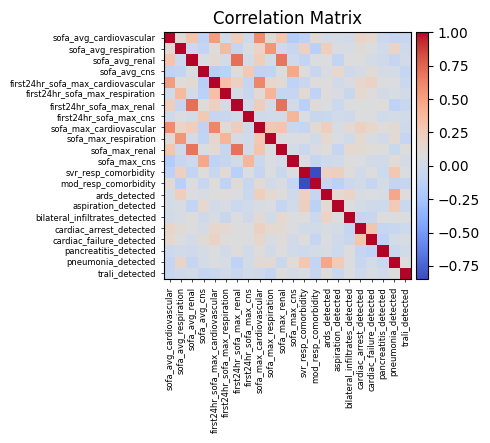

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np  # ensure this is imported if not already

names2 = list(C_cont.columns) + list(C_bin.columns) + list(LLM_C.columns)
names = [name[2:] if i <= 13 else name for i, name in enumerate(names2)]

fig, ax = plt.subplots(figsize=(5, 5))
all_concepts = np.concatenate([test_concepts, test_llm_concepts], axis=1)
corr = np.corrcoef(all_concepts, rowvar=False)

im = ax.imshow(corr, cmap='coolwarm')

# Create an axis on the right of ax for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax.set_title("Correlation Matrix", fontsize=12)
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90, fontsize=6, fontweight='medium')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(names, fontsize=6, fontweight='medium')

# Improve tick visibility
ax.tick_params(axis='both', which='major', length=2.5, width=0.5)

# Tight layout and remove whitespace when saving
plt.tight_layout()
plt.savefig("correlations.png", dpi=300, bbox_inches='tight')
plt.show()

## Correlated corrections over enhanced CBMs: Main intervention on vanilla using GT, translate to all, including LLM concepts

In [52]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_negatives_idx_llm:

        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = test_concepts[a][change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        d = test_llm_concepts[a].copy()
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta
    
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False negatives corrections:",count/total,count, total)

print("----------------------")
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_positives_idx_llm:

        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = test_concepts[a][change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] - corr[change,val]*delta
        
        d = test_llm_concepts[a].copy()
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] - corr[change,val]*delta
    
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False positives corrections:",count/total,count, total)

Intervention index 0 False negatives corrections: 0.36363636363636365 8 22
Intervention index 1 False negatives corrections: 0.45454545454545453 10 22
Intervention index 2 False negatives corrections: 0.22727272727272727 5 22
Intervention index 3 False negatives corrections: 0.2727272727272727 6 22
Intervention index 4 False negatives corrections: 0.2727272727272727 6 22
Intervention index 5 False negatives corrections: 0.18181818181818182 4 22
Intervention index 6 False negatives corrections: 0.3181818181818182 7 22
Intervention index 7 False negatives corrections: 0.18181818181818182 4 22
Intervention index 8 False negatives corrections: 0.18181818181818182 4 22
Intervention index 9 False negatives corrections: 0.18181818181818182 4 22
Intervention index 10 False negatives corrections: 0.2727272727272727 6 22
Intervention index 11 False negatives corrections: 0.2727272727272727 6 22
Intervention index 12 False negatives corrections: 0.7272727272727273 16 22
Intervention index 13 Fals

## Correlated corrections over enhanced CBMs: Main intervention on vanilla using mean, translate to all, including LLM concepts

In [53]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_negatives_idx_llm:

        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.mean(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        d = test_llm_concepts[a].copy()
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta
    
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False negatives corrections:",count/total,count, total)

print("----------------------")
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_positives_idx_llm:

        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.mean(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] - corr[change,val]*delta
        
        d = test_llm_concepts[a].copy()
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] - corr[change,val]*delta
    
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False positives corrections:",count/total,count, total)

Intervention index 0 False negatives corrections: 0.3181818181818182 7 22
Intervention index 1 False negatives corrections: 0.45454545454545453 10 22
Intervention index 2 False negatives corrections: 0.18181818181818182 4 22
Intervention index 3 False negatives corrections: 0.2727272727272727 6 22
Intervention index 4 False negatives corrections: 0.36363636363636365 8 22
Intervention index 5 False negatives corrections: 0.18181818181818182 4 22
Intervention index 6 False negatives corrections: 0.45454545454545453 10 22
Intervention index 7 False negatives corrections: 0.18181818181818182 4 22
Intervention index 8 False negatives corrections: 0.18181818181818182 4 22
Intervention index 9 False negatives corrections: 0.18181818181818182 4 22
Intervention index 10 False negatives corrections: 0.22727272727272727 5 22
Intervention index 11 False negatives corrections: 0.22727272727272727 5 22
Intervention index 12 False negatives corrections: 0.5 11 22
Intervention index 13 False negatives

## Correlated corrections over enhanced CBMs: Main intervention on vanilla using median, translate to all, including LLM concepts

In [54]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_negatives_idx_llm:

        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.median(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        d = test_llm_concepts[a].copy()
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta
    
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False negatives corrections:",count/total,count, total)

print("----------------------")
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_positives_idx_llm:

        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.median(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] - corr[change,val]*delta
        
        d = test_llm_concepts[a].copy()
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] - corr[change,val]*delta
    
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False positives corrections:",count/total,count, total)

Intervention index 0 False negatives corrections: 0.2727272727272727 6 22
Intervention index 1 False negatives corrections: 0.45454545454545453 10 22
Intervention index 2 False negatives corrections: 0.18181818181818182 4 22
Intervention index 3 False negatives corrections: 0.2727272727272727 6 22
Intervention index 4 False negatives corrections: 0.2727272727272727 6 22
Intervention index 5 False negatives corrections: 0.18181818181818182 4 22
Intervention index 6 False negatives corrections: 0.45454545454545453 10 22
Intervention index 7 False negatives corrections: 0.18181818181818182 4 22
Intervention index 8 False negatives corrections: 0.22727272727272727 5 22
Intervention index 9 False negatives corrections: 0.18181818181818182 4 22
Intervention index 10 False negatives corrections: 0.22727272727272727 5 22
Intervention index 11 False negatives corrections: 0.22727272727272727 5 22
Intervention index 12 False negatives corrections: 0.8181818181818182 18 22
Intervention index 13 F

## Correlated corrections over enhanced CBMs using ground truth: Main intervention on LLM, translate to all

In [55]:
intervention_concept_idxs = [14,15,16,17,18,19,20,21]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_negatives_idx_llm:

        d = test_llm_concepts[a].copy()
        orig_value = d[change-14] 
        d[change-14] = 1.0
        delta = orig_value-d[change-14]
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta

        b = c_pred[a].copy()
    
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False negatives corrections:",count/total,count, total)

print("----------------")
intervention_concept_idxs = [14,15,16,17,18,19,20,21]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_positives_idx_llm:

        d = test_llm_concepts[a].copy()
        orig_value = d[change-14] 
        d[change-14] = 0.0
        delta = orig_value-d[change-14]
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta

        b = c_pred[a].copy()
    
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False positives corrections:",count/total,count, total)

Intervention index 14 False negatives corrections: 0.3181818181818182 7 22
Intervention index 15 False negatives corrections: 0.18181818181818182 4 22
Intervention index 16 False negatives corrections: 0.22727272727272727 5 22
Intervention index 17 False negatives corrections: 0.2727272727272727 6 22
Intervention index 18 False negatives corrections: 0.13636363636363635 3 22
Intervention index 19 False negatives corrections: 0.45454545454545453 10 22
Intervention index 20 False negatives corrections: 0.36363636363636365 8 22
Intervention index 21 False negatives corrections: 0.045454545454545456 1 22
----------------
Intervention index 14 False positives corrections: 0.2 11 55
Intervention index 15 False positives corrections: 0.16363636363636364 9 55
Intervention index 16 False positives corrections: 0.3090909090909091 17 55
Intervention index 17 False positives corrections: 0.16363636363636364 9 55
Intervention index 18 False positives corrections: 0.09090909090909091 5 55
Interventi

## Correlated corrections over enhanced CBMs using mean: Main intervention on LLM, translate to all

In [56]:
intervention_concept_idxs = [14,15,16,17,18,19,20,21]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_negatives_idx_llm:

        d = test_llm_concepts[a].copy()
        orig_value = d[change-14] 
        d[change-14] = np.mean(test_llm_concepts,axis=0)[change-14]
        delta = orig_value-d[change-14]
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta

        b = c_pred[a].copy()
    
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False negatives corrections:",count/total,count, total)

print("----------------")
intervention_concept_idxs = [14,15,16,17,18,19,20,21]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_positives_idx_llm:

        d = test_llm_concepts[a].copy()
        orig_value = d[change-14] 
        d[change-14] = np.mean(test_llm_concepts,axis=0)[change-14]
        delta = orig_value-d[change-14]
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta

        b = c_pred[a].copy()
    
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False positives corrections:",count/total,count, total)

Intervention index 14 False negatives corrections: 0.2727272727272727 6 22
Intervention index 15 False negatives corrections: 0.18181818181818182 4 22
Intervention index 16 False negatives corrections: 0.22727272727272727 5 22
Intervention index 17 False negatives corrections: 0.18181818181818182 4 22
Intervention index 18 False negatives corrections: 0.36363636363636365 8 22
Intervention index 19 False negatives corrections: 0.2727272727272727 6 22
Intervention index 20 False negatives corrections: 0.3181818181818182 7 22
Intervention index 21 False negatives corrections: 0.18181818181818182 4 22
----------------
Intervention index 14 False positives corrections: 0.14545454545454545 8 55
Intervention index 15 False positives corrections: 0.16363636363636364 9 55
Intervention index 16 False positives corrections: 0.2 11 55
Intervention index 17 False positives corrections: 0.16363636363636364 9 55
Intervention index 18 False positives corrections: 0.18181818181818182 10 55
Intervention

## Correlated corrections over enhanced CBMs using median: Main intervention on LLM, translate to all

In [57]:
intervention_concept_idxs = [14,15,16,17,18,19,20,21]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_negatives_idx_llm:

        d = test_llm_concepts[a].copy()
        orig_value = d[change-14] 
        d[change-14] = np.median(test_llm_concepts,axis=0)[change-14]
        delta = orig_value-d[change-14]
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta

        b = c_pred[a].copy()
    
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False negatives corrections:",count/total,count, total)

print("----------------")
intervention_concept_idxs = [14,15,16,17,18,19,20,21]

for change in intervention_concept_idxs:
    count = 0
    total = 0

    for a in false_positives_idx_llm:

        d = test_llm_concepts[a].copy()
        orig_value = d[change-14] 
        d[change-14] = np.median(test_llm_concepts,axis=0)[change-14]
        delta = orig_value-d[change-14]
        
        for val in [q for q in range(14,22) if q!=change]:
            
            d[val-14] = d[val-14] + corr[change,val]*delta

        b = c_pred[a].copy()
    
        for val in [q for q in range(14) if q!=change]:
            
            b[val] = b[val] + corr[change,val]*delta
        
        with torch.no_grad():
            p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Intervention index",change,"False positives corrections:",count/total,count, total)

Intervention index 14 False negatives corrections: 0.3181818181818182 7 22
Intervention index 15 False negatives corrections: 0.18181818181818182 4 22
Intervention index 16 False negatives corrections: 0.22727272727272727 5 22
Intervention index 17 False negatives corrections: 0.18181818181818182 4 22
Intervention index 18 False negatives corrections: 0.13636363636363635 3 22
Intervention index 19 False negatives corrections: 0.18181818181818182 4 22
Intervention index 20 False negatives corrections: 0.36363636363636365 8 22
Intervention index 21 False negatives corrections: 0.18181818181818182 4 22
----------------
Intervention index 14 False positives corrections: 0.10909090909090909 6 55
Intervention index 15 False positives corrections: 0.16363636363636364 9 55
Intervention index 16 False positives corrections: 0.14545454545454545 8 55
Intervention index 17 False positives corrections: 0.16363636363636364 9 55
Intervention index 18 False positives corrections: 0.2545454545454545 14

## Correlated concept: Multiple main interventions using ground truth, translated to all, including LLMs

In [58]:
count = 0
total = 0

for a in false_negatives_idx_llm:

    b = c_pred[a].copy()

    orig_value1 = b[1]
    b[1] = test_concepts[a][1]
    delta1 = orig_value1 - b[1]

    orig_value2 = b[12]
    b[12] = test_concepts[a][12]
    delta2 = orig_value2 - b[12]

    d = test_llm_concepts[a].copy()
    orig_value3 = d[5] 
    d[5] = 1.0
    delta3 = orig_value-d[5]

    for val in [q for q in range(14) if q not in [1,12]]:
        
        b[val] = b[val] + corr[1,val]*delta1 + corr[12,val]*delta2 + corr[19,val]*delta3
    
    d = test_llm_concepts[a].copy()
    
    for val in [q for q in range(14,22) if q not in [19]]:
        
        d[val-14] = d[val-14] + corr[1,val]*delta1 + corr[12,val]*delta2 + corr[19,val]*delta3

    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count, total)

print("----------------------")

count = 0
total = 0

for a in false_positives_idx_llm:

    b = c_pred[a].copy()

    orig_value1 = b[12]
    b[12] = test_concepts[a][12]
    delta1 = orig_value1 - b[12]

    orig_value2 = b[13]
    b[13] = test_concepts[a][13]
    delta2 = orig_value2 - b[13]

    d = test_llm_concepts[a].copy()
    orig_value3 = d[6] 
    d[6] = 0.0
    delta3 = orig_value-d[6]
    
    for val in [q for q in range(14) if q not in [12,13]]:
        
        b[val] = b[val] + corr[13,val]*delta2  + corr[12,val]*delta1 + corr[20,val]*delta3
    
    for val in [q for q in range(14,22) if q not in [20]]:
        
        d[val-14] = d[val-14] + corr[13,val]*delta2 + corr[12,val]*delta1 + corr[20,val]*delta3

    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count, total)

False negatives corrections: 0.8181818181818182 18 22
----------------------
False positives corrections: 0.8181818181818182 45 55


## Correlated concept: Multiple main interventions using mean, translated to all, including LLMs

In [59]:
count = 0
total = 0

for a in false_negatives_idx_llm:

    b = c_pred[a].copy()

    orig_value1 = b[1]
    b[1] = np.mean(test_concepts,axis=0)[1]
    delta1 = orig_value1 - b[1]

    orig_value2 = b[12]
    b[12] = np.mean(test_concepts,axis=0)[12]
    delta2 = orig_value2 - b[12]

    d = test_llm_concepts[a].copy()
    orig_value3 = d[5] 
    d[5] = np.mean(test_llm_concepts,axis=0)[5]
    delta3 = orig_value-d[5]

    for val in [q for q in range(14) if q not in [1,12]]:
        
        b[val] = b[val] + corr[1,val]*delta1 + corr[12,val]*delta2 + corr[19,val]*delta3
    
    d = test_llm_concepts[a].copy()
    
    for val in [q for q in range(14,22) if q not in [19]]:
        
        d[val-14] = d[val-14] + corr[1,val]*delta1 + corr[12,val]*delta2 + corr[19,val]*delta3

    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count, total)

print("----------------------")

count = 0
total = 0

for a in false_positives_idx_llm:

    b = c_pred[a].copy()

    orig_value1 = b[12]
    b[12] = np.mean(test_concepts,axis=0)[12]
    delta1 = orig_value1 - b[12]

    orig_value2 = b[13]
    b[13] = np.mean(test_concepts,axis=0)[13]
    delta2 = orig_value2 - b[13]

    d = test_llm_concepts[a].copy()
    orig_value3 = d[6] 
    d[6] = np.mean(test_llm_concepts,axis=0)[6]
    delta3 = orig_value-d[6]
    
    for val in [q for q in range(14) if q not in [12,13]]:
        
        b[val] = b[val] + corr[13,val]*delta2  + corr[12,val]*delta1 + corr[20,val]*delta3
    
    for val in [q for q in range(14,22) if q not in [20]]:
        
        d[val-14] = d[val-14] + corr[13,val]*delta2 + corr[12,val]*delta1 + corr[20,val]*delta3

    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count, total)

False negatives corrections: 0.6818181818181818 15 22
----------------------
False positives corrections: 0.5636363636363636 31 55


## Correlated concept: Multiple main interventions using median, translated to all, including LLMs

In [60]:
count = 0
total = 0

for a in false_negatives_idx_llm:

    b = c_pred[a].copy()

    orig_value1 = b[1]
    b[1] = np.mean(test_concepts,axis=0)[1]
    delta1 = orig_value1 - b[1]

    orig_value2 = b[12]
    b[12] = np.mean(test_concepts,axis=0)[12]
    delta2 = orig_value2 - b[12]

    d = test_llm_concepts[a].copy()
    orig_value3 = d[5] 
    d[5] = np.mean(test_llm_concepts,axis=0)[5]
    delta3 = orig_value-d[5]

    for val in [q for q in range(14) if q not in [1,12]]:
        
        b[val] = b[val] + corr[1,val]*delta1 + corr[12,val]*delta2 + corr[19,val]*delta3
    
    d = test_llm_concepts[a].copy()
    
    for val in [q for q in range(14,22) if q not in [19]]:
        
        d[val-14] = d[val-14] + corr[1,val]*delta1 + corr[12,val]*delta2 + corr[19,val]*delta3

    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))

    if p_int>=0.5:
        count+=1
    total+=1
    
print("False negatives corrections:",count/total,count, total)

print("----------------------")

count = 0
total = 0

for a in false_positives_idx_llm:

    b = c_pred[a].copy()

    orig_value1 = b[12]
    b[12] = np.median(test_concepts,axis=0)[12]
    delta1 = orig_value1 - b[12]

    orig_value2 = b[13]
    b[13] = np.median(test_concepts,axis=0)[13]
    delta2 = orig_value2 - b[13]

    idx = 6
    d = test_llm_concepts[a].copy()
    orig_value3 = d[idx] 
    d[idx] = np.median(test_llm_concepts,axis=0)[idx]
    delta3 = orig_value-d[idx]
    
    for val in [q for q in range(14) if q not in [12,13]]:
        
        b[val] = b[val] + corr[13,val]*delta2  + corr[12,val]*delta1 + corr[idx+14,val]*delta3
    
    for val in [q for q in range(14,22) if q not in [idx+14]]:
        
        d[val-14] = d[val-14] + corr[13,val]*delta2 + corr[12,val]*delta1 + corr[idx+14,val]*delta3

    with torch.no_grad():
        p_int = model_int6(torch.tensor(test_features[a:a+1]),torch.tensor([b[-2:]]),torch.tensor([b[:-2]]),torch.tensor([d]))

    if p_int<=0.5:
        count+=1
    total+=1
    
print("False positives corrections:",count/total,count, total)

False negatives corrections: 0.6818181818181818 15 22
----------------------
False positives corrections: 0.6363636363636364 35 55


## Correlated Concept corrections over vanilla CBMs

### GT

In [61]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]

for change in intervention_concept_idxs:

    count = 0
    total = 0
    
    for a in false_negatives_idx:
        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = test_concepts[a][change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(12) if q!=change]:
            #orig = b[val]
            #new = test_concepts[a][val]
            #delta = orig-new
            
            b[val] = b[val] + corr[change,val]*delta
            
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",change,"False negatives corrections:",count/total,count,total)

for change in intervention_concept_idxs:

    count = 0
    total = 0
    
    for a in false_positives_idx:
        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = test_concepts[a][change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(12) if q!=change]:
            #orig = b[val]
            #new = test_concepts[a][val]
            #delta = orig-new
            
            b[val] = b[val] + corr[change,val]*delta
            
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",change,"False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.03896103896103896 3 77
Int concept 1 False negatives corrections: 0.06493506493506493 5 77
Int concept 2 False negatives corrections: 0.18181818181818182 14 77
Int concept 3 False negatives corrections: 0.1038961038961039 8 77
Int concept 4 False negatives corrections: 0.06493506493506493 5 77
Int concept 5 False negatives corrections: 0.07792207792207792 6 77
Int concept 6 False negatives corrections: 0.24675324675324675 19 77
Int concept 7 False negatives corrections: 0.06493506493506493 5 77
Int concept 8 False negatives corrections: 0.06493506493506493 5 77
Int concept 9 False negatives corrections: 0.06493506493506493 5 77
Int concept 10 False negatives corrections: 0.4675324675324675 36 77
Int concept 11 False negatives corrections: 0.06493506493506493 5 77
Int concept 0 False positives corrections: 0.6086956521739131 28 46
Int concept 1 False positives corrections: 0.8913043478260869 41 46
Int concept 2 False positives corrections: 0.

### Mean

In [62]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]

for change in intervention_concept_idxs:

    count = 0
    total = 0
    
    for a in false_negatives_idx:
        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.mean(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(12) if q!=change]:
            #orig = b[val]
            #new = test_concepts[a][val]
            #delta = orig-new
            
            b[val] = b[val] + corr[change,val]*delta
            
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",change,"False negatives corrections:",count/total,count,total)

for change in intervention_concept_idxs:

    count = 0
    total = 0
    
    for a in false_positives_idx:
        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.mean(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(12) if q!=change]:
            #orig = b[val]
            #new = test_concepts[a][val]
            #delta = orig-new
            
            b[val] = b[val] + corr[change,val]*delta
            
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",change,"False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.05194805194805195 4 77
Int concept 1 False negatives corrections: 0.06493506493506493 5 77
Int concept 2 False negatives corrections: 0.025974025974025976 2 77
Int concept 3 False negatives corrections: 0.1038961038961039 8 77
Int concept 4 False negatives corrections: 0.06493506493506493 5 77
Int concept 5 False negatives corrections: 0.07792207792207792 6 77
Int concept 6 False negatives corrections: 0.18181818181818182 14 77
Int concept 7 False negatives corrections: 0.06493506493506493 5 77
Int concept 8 False negatives corrections: 0.06493506493506493 5 77
Int concept 9 False negatives corrections: 0.06493506493506493 5 77
Int concept 10 False negatives corrections: 0.33766233766233766 26 77
Int concept 11 False negatives corrections: 0.06493506493506493 5 77
Int concept 0 False positives corrections: 0.6086956521739131 28 46
Int concept 1 False positives corrections: 0.8695652173913043 40 46
Int concept 2 False positives corrections: 0

### Median

In [63]:
intervention_concept_idxs = [0,1,2,3,4,5,6,7,8,9,10,11]

for change in intervention_concept_idxs:

    count = 0
    total = 0
    
    for a in false_negatives_idx:
        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.median(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(12) if q!=change]:
            #orig = b[val]
            #new = test_concepts[a][val]
            #delta = orig-new
            
            b[val] = b[val] + corr[change,val]*delta
            
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int>=0.5:
            count+=1
        total+=1
        
    print("Int concept",change,"False negatives corrections:",count/total,count,total)

for change in intervention_concept_idxs:

    count = 0
    total = 0
    
    for a in false_positives_idx:
        b = c_pred[a].copy()
    
        orig_value = b[change] 
        b[change] = np.median(test_concepts,axis=0)[change]
        delta = orig_value-b[change]
        
        for val in [q for q in range(12) if q!=change]:
            #orig = b[val]
            #new = test_concepts[a][val]
            #delta = orig-new
            
            b[val] = b[val] + corr[change,val]*delta
            
        b = b[:-2]
        
        p_int = model_int2(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float())
    
        if p_int<=0.5:
            count+=1
        total+=1
        
    print("Int concept",change,"False positives corrections:",count/total,count,total)

Int concept 0 False negatives corrections: 0.06493506493506493 5 77
Int concept 1 False negatives corrections: 0.06493506493506493 5 77
Int concept 2 False negatives corrections: 0.012987012987012988 1 77
Int concept 3 False negatives corrections: 0.1038961038961039 8 77
Int concept 4 False negatives corrections: 0.06493506493506493 5 77
Int concept 5 False negatives corrections: 0.07792207792207792 6 77
Int concept 6 False negatives corrections: 0.24675324675324675 19 77
Int concept 7 False negatives corrections: 0.06493506493506493 5 77
Int concept 8 False negatives corrections: 0.06493506493506493 5 77
Int concept 9 False negatives corrections: 0.06493506493506493 5 77
Int concept 10 False negatives corrections: 0.36363636363636365 28 77
Int concept 11 False negatives corrections: 0.06493506493506493 5 77
Int concept 0 False positives corrections: 0.6086956521739131 28 46
Int concept 1 False positives corrections: 0.8695652173913043 40 46
Int concept 2 False positives corrections: 0

# Case studies

In [64]:
true_positives_idx

array([  0,   1,   2,   3,  10,  12,  19,  24,  35,  36,  37,  38,  44,
        45,  50,  51,  53,  56,  57,  58,  67,  76,  77,  84,  85,  88,
        92,  94, 106, 107, 108, 113, 116, 117, 120, 123, 125, 126, 129,
       130, 131, 133, 135, 137, 140, 145, 147, 150, 157, 159, 160, 161,
       164, 165, 166, 167, 172, 173, 174, 175, 180, 189, 191, 192, 195,
       198, 200, 202, 204, 212, 213, 219, 220, 221, 227, 231, 237, 239,
       240, 251, 253, 257, 259, 262, 265, 273, 275, 280, 283, 289, 291,
       293, 296, 297, 299, 301, 303, 307, 311, 313, 320, 322, 323, 325,
       326, 330, 334, 335, 336, 339, 342, 348, 356, 357, 360, 363, 364,
       365, 366, 367, 369, 370, 371, 373, 375, 376, 377, 382, 384, 389,
       390])

In [65]:
false_positives_idx

array([  7,  15,  18,  22,  25,  33,  54,  74,  82,  98, 100, 101, 110,
       114, 118, 134, 142, 144, 171, 177, 178, 181, 184, 186, 201, 208,
       209, 214, 217, 218, 223, 234, 236, 247, 248, 252, 258, 279, 288,
       292, 315, 318, 327, 350, 368, 388])

In [66]:
false_negatives_idx

array([  8,   9,  11,  14,  16,  31,  39,  46,  49,  52,  55,  59,  62,
        64,  66,  68,  73,  93, 102, 103, 105, 119, 121, 127, 128, 132,
       139, 149, 152, 153, 154, 158, 169, 170, 179, 182, 185, 188, 193,
       199, 205, 207, 210, 215, 225, 226, 230, 232, 249, 255, 263, 264,
       266, 269, 272, 274, 281, 282, 284, 287, 294, 305, 310, 312, 317,
       331, 340, 346, 347, 349, 353, 358, 362, 374, 380, 386, 387])

In [67]:
false_positives_idx_llm

array([  7,  22,  23,  25,  33,  42,  54,  60,  65,  69,  79,  82,  83,
        91,  95,  98, 100, 101, 104, 111, 134, 136, 141, 144, 168, 171,
       177, 178, 181, 184, 186, 201, 206, 209, 214, 217, 218, 222, 223,
       245, 248, 254, 270, 288, 315, 318, 327, 328, 333, 350, 361, 368,
       372, 378, 388])

In [68]:
false_negatives_idx_llm

array([  8,   9,  16,  52,  59,  62,  93, 107, 128, 158, 182, 188, 191,
       193, 195, 220, 226, 281, 296, 317, 331, 374])

In [69]:
test_concepts.shape, test_llm_concepts.shape

((391, 14), (391, 8))

In [70]:
np.setdiff1d(false_negatives_idx_llm, false_negatives_idx)

array([107, 191, 195, 220, 296])

In [71]:
np.setdiff1d(false_positives_idx_llm, false_positives_idx)

array([ 23,  42,  60,  65,  69,  79,  83,  91,  95, 104, 111, 136, 141,
       168, 206, 222, 245, 254, 270, 328, 333, 361, 372, 378])

In [72]:
def patient_info(idx):
    features_list = ['max_norepinephrine_equiv', 'avg_norepinephrine_equiv', 'sofa_cardiovascular_avg_meanbp',
                      'sofa_cardiovascular_avg_rate_norepinephrine', 'sofa_respiration_avg_pao2fio2ratio',
                      'sofa_renal_avg_urineoutput', 'sofa_renal_avg_creatinine', 'sofa_cns_avg_gcs', 
                     'first24hr_cardiovascular_meanbp','sofa_cardiovascular_worst_meanbp',
                      'sofa_cardiovascular_worst_rate_norepinephrine', 'sofa_respiration_worst_pao2fio2ratio',
                      'sofa_renal_worst_urineoutput', 'sofa_cns_worst_gcs','mech_vent_duration_minutes']
    
    features = processor.x_scaler.inverse_transform(test_features[idx:idx+1,:15])

    features_binary_list = ['other_respiratory_diseases', 'lung_diseases_due_to_external_agents',
                         'chronic_lower_respiratory_diseases', 'acute_lower_respiratory_infections',
                         'influenza_pneumonia', 'upper_respiratory_infections']
    
    features_binary = test_features[idx:idx+1,15:]
    
    print("--------Features-------")
    for i in range(15):
        print(features_list[i], features[0,i])
    for i in range(15,21):
        print(features_binary_list[15-i],features_binary[0,15-i])
    
    concept_list = ['c_sofa_avg_cardiovascular', 'c_sofa_avg_respiration', 'c_sofa_avg_renal', 
                    'c_sofa_avg_cns', 'c_first24hr_sofa_max_cardiovascular', 'c_first24hr_sofa_max_respiration', 
                    'c_first24hr_sofa_max_renal', 'c_first24hr_sofa_max_cns', 'c_sofa_max_cardiovascular', 
                    'c_sofa_max_respiration', 'c_sofa_max_renal', 'c_sofa_max_cns']
    
    concept_bin_list = ['c_svr_resp_comorbidity', 'c_mod_resp_comorbidity']
    
    true_cont_concepts = processor.c_scaler.inverse_transform(test_concepts[idx:idx+1,:12])
    pred_cont_concepts = processor.c_scaler.inverse_transform(c_pred[idx:idx+1,:12])
    true_binary_concepts = test_concepts[idx:idx+1,12:14]
    pred_binary_concepts = c_pred[idx:idx+1,12:14]
    llm_list = list(LLM_C.columns)
    llm_concepts = test_llm_concepts[idx:idx+1]
    
    print("--------Concepts--------")
    for i in range(12):
        print(concept_list[i],"True:",true_cont_concepts[0,i],"Pred:",pred_cont_concepts[0,i])
    for i in range(2):
        print(concept_bin_list[i],"True:",true_binary_concepts[0,i],"Pred:",pred_binary_concepts[0,i])
    
    for i in range(8):
        print(llm_list[i],llm_concepts[0,i])

In [73]:
y_pred[0], y_pred[1], y_pred[2], y_pred[3]

(0.58577484, 0.5937679, 0.8659679, 0.9416028)

In [74]:
patient_info(0)

--------Features-------
max_norepinephrine_equiv 0.25059998
avg_norepinephrine_equiv 0.0730783
sofa_cardiovascular_avg_meanbp 77.1
sofa_cardiovascular_avg_rate_norepinephrine 0.07346412
sofa_respiration_avg_pao2fio2ratio 166.39394
sofa_renal_avg_urineoutput 2067.5427
sofa_renal_avg_creatinine 1.1185185
sofa_cns_avg_gcs 14.815789
first24hr_cardiovascular_meanbp 81.0
sofa_cardiovascular_worst_meanbp 68.0
sofa_cardiovascular_worst_rate_norepinephrine 0.15043026
sofa_respiration_worst_pao2fio2ratio 88.0
sofa_renal_worst_urineoutput 436.73465
sofa_cns_worst_gcs 5.0
mech_vent_duration_minutes 14459.999
other_respiratory_diseases 1.0
upper_respiratory_infections 0.0
influenza_pneumonia 0.0
acute_lower_respiratory_infections 0.0
chronic_lower_respiratory_diseases 0.0
lung_diseases_due_to_external_agents 1.0
--------Concepts--------
c_sofa_avg_cardiovascular True: 1.4495413 Pred: 0.14781882
c_sofa_avg_respiration True: 2.848485 Pred: 3.7923257
c_sofa_avg_renal True: 0.22362868 Pred: 0.9881459
c

In [75]:
patient_info(3)

--------Features-------
max_norepinephrine_equiv 0.20019999
avg_norepinephrine_equiv 0.084288724
sofa_cardiovascular_avg_meanbp 91.6631
sofa_cardiovascular_avg_rate_norepinephrine 0.07451578
sofa_respiration_avg_pao2fio2ratio 145.34703
sofa_renal_avg_urineoutput 221.62918
sofa_renal_avg_creatinine 4.418182
sofa_cns_avg_gcs 13.817073
first24hr_cardiovascular_meanbp 68.0
sofa_cardiovascular_worst_meanbp 80.0
sofa_cardiovascular_worst_rate_norepinephrine 0.10002754
sofa_respiration_worst_pao2fio2ratio 83.0
sofa_renal_worst_urineoutput 80.99999
sofa_cns_worst_gcs 3.0
mech_vent_duration_minutes 18060.0
other_respiratory_diseases 1.0
upper_respiratory_infections 0.0
influenza_pneumonia 1.0
acute_lower_respiratory_infections 0.0
chronic_lower_respiratory_diseases 0.0
lung_diseases_due_to_external_agents 1.0
--------Concepts--------
c_sofa_avg_cardiovascular True: 0.47860962 Pred: 3.9420629
c_sofa_avg_respiration True: 3.0 Pred: 2.1404853
c_sofa_avg_renal True: 3.4114585 Pred: -0.22874808
c_so

In [76]:
X_cont[['max_norepinephrine_equiv', 'avg_norepinephrine_equiv', 'sofa_cardiovascular_avg_meanbp',
      'sofa_cardiovascular_avg_rate_norepinephrine', 'sofa_respiration_avg_pao2fio2ratio',
      'sofa_renal_avg_urineoutput', 'sofa_renal_avg_creatinine', 'sofa_cns_avg_gcs', 'first24hr_cardiovascular_meanbp',
      'sofa_cardiovascular_worst_meanbp',
      'sofa_cardiovascular_worst_rate_norepinephrine', 'sofa_respiration_worst_pao2fio2ratio',
      'sofa_renal_worst_urineoutput', 'sofa_cns_worst_gcs',
      'mech_vent_duration_minutes']].describe()

,max_norepinephrine_equiv,avg_norepinephrine_equiv,sofa_cardiovascular_avg_meanbp,sofa_cardiovascular_avg_rate_norepinephrine,sofa_respiration_avg_pao2fio2ratio,sofa_renal_avg_urineoutput,sofa_renal_avg_creatinine,sofa_cns_avg_gcs,first24hr_cardiovascular_meanbp,sofa_cardiovascular_worst_meanbp,sofa_cardiovascular_worst_rate_norepinephrine,sofa_respiration_worst_pao2fio2ratio,sofa_renal_worst_urineoutput,sofa_cns_worst_gcs,mech_vent_duration_minutes
count,1954.000000,1954.000000,1954.000000,1319.000000,1951.000000,1920.000000,1952.000000,1954.000000,1815.000000,1886.000000,1296.000000,1951.000000,1554.000000,1954.000000,1954.000000
mean,0.870311,0.146885,76.945346,0.134594,210.566431,2087.808411,1.646029,14.518385,72.589715,68.389449,0.183187,129.603604,1553.551509,8.847492,12725.556295
std,3.981872,0.591864,8.427606,0.097126,52.625603,1196.591774,1.224079,0.623983,15.624567,12.193167,0.132894,53.128289,1543.058064,4.421967,11124.264245
min,0.000000,0.000000,54.091667,0.012503,58.189474,-1.211422,0.100000,5.322581,1.000000,1.000000,0.010000,33.000000,-750.000000,3.000000,0.000000
25%,0.100000,0.044340,71.089230,0.064741,174.193328,1196.169735,0.814123,14.375000,64.000000,62.000000,0.100118,86.000000,188.250000,4.000000,5460.000000
50%,0.300400,0.095712,75.956906,0.105278,206.530021,2150.340131,1.246761,14.683624,71.000000,67.750000,0.149554,118.333333,1074.000000,9.000000,9420.000000
75%,0.631525,0.175445,82.008346,0.175398,245.076077,2893.864229,2.109357,14.887671,80.000000,74.000000,0.222757,175.000000,2503.750000,14.000000,16559.500000
max,100.110300,25.396800,112.014870,0.676265,409.733432,7812.156434,10.300000,15.000000,261.000000,131.000000,1.141252,298.000000,7675.000000,15.000000,86520.000000


In [77]:
C_cont[['c_sofa_avg_cardiovascular', 'c_sofa_avg_respiration', 'c_sofa_avg_renal', 
        'c_sofa_avg_cns', 'c_first24hr_sofa_max_cardiovascular', 'c_first24hr_sofa_max_respiration', 
        'c_first24hr_sofa_max_renal', 'c_first24hr_sofa_max_cns', 'c_sofa_max_cardiovascular', 
        'c_sofa_max_respiration', 'c_sofa_max_renal', 'c_sofa_max_cns']].describe()

,c_sofa_avg_cardiovascular,c_sofa_avg_respiration,c_sofa_avg_renal,c_sofa_avg_cns,c_first24hr_sofa_max_cardiovascular,c_first24hr_sofa_max_respiration,c_first24hr_sofa_max_renal,c_first24hr_sofa_max_cns,c_sofa_max_cardiovascular,c_sofa_max_respiration,c_sofa_max_renal,c_sofa_max_cns
count,1954.000000,1951.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1954.000000,1951.000000,1954.000000,1954.000000
mean,1.124533,2.328115,0.617148,0.238392,2.315763,2.586489,1.195496,0.713408,2.994371,3.415684,2.048106,2.440123
std,1.058069,0.490933,0.997015,0.264275,1.491085,1.251703,1.282303,1.243418,1.331592,0.597379,1.557480,1.384482
min,0.000000,0.855670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.290368,2.000000,0.005510,0.071429,1.000000,2.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000
50%,0.757726,2.329843,0.110703,0.173762,3.000000,3.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000
75%,1.632093,2.666667,0.733047,0.314683,4.000000,3.000000,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000
max,4.000000,4.000000,4.000000,3.505376,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


### Test Patient index 31: False negative by Vanilla CBM (0.24), corrected by Enhanced CBM (0.86)

In [78]:
y_pred[31], y_pred_llm[31]

(0.2489348, 0.8640127)

In [79]:
test_concepts[31], test_llm_concepts[31]

(array([0.39285713, 0.72704715, 0.5458377 , 0.02113156, 0.25      ,
        0.        , 0.        , 0.5       , 1.        , 1.        ,
        1.        , 0.5       , 0.        , 1.        ], dtype=float32),
 array([1., 0., 1., 0., 0., 0., 1., 0.], dtype=float32))

In [80]:
c_pred[31], c_pred_llm[31]

(array([3.0823460e-06, 9.9885082e-01, 1.0387356e+00, 1.0186465e+00,
        7.1420133e-02, 7.7194888e-03, 1.0523874e+00, 5.7827437e-01,
        5.6075913e-01, 8.8978507e-02, 1.2178097e+00, 8.4553605e-01,
        4.2539081e-01, 4.6223098e-01], dtype=float32),
 array([ 2.8295588e-05,  9.9593914e-01,  8.3711737e-01,  6.8686098e-01,
         5.4518235e-01,  4.7256779e-02,  8.4858847e-01,  7.0724684e-01,
        -5.4663658e-02,  1.7693353e-01,  1.0362664e+00,  9.4690055e-01,
         9.3202239e-01,  5.9369648e-01], dtype=float32))

### Test Patient index 68: False negative by Vanilla CBM (0.24), corrected by Enhanced CBM (0.86)

In [81]:
y_pred[68],y_pred_llm[68]

(0.21801202, 0.88308203)

In [82]:
test_concepts[68], test_llm_concepts[68]

(array([0.2757235 , 0.3548387 , 0.01657918, 0.1384428 , 0.75      ,
        0.        , 0.75      , 0.        , 1.        , 0.5       ,
        0.75      , 0.5       , 0.        , 1.        ], dtype=float32),
 array([1., 1., 1., 0., 1., 0., 1., 0.], dtype=float32))

In [83]:
c_pred[68], c_pred_llm[68]

(array([ 4.3182704e-03,  9.6764195e-01,  5.7537967e-01,  8.5416883e-02,
        -6.2954426e-04,  1.1717834e-01,  9.2453039e-01,  3.3428958e-01,
         4.0201780e-01,  8.4963918e-02,  1.2879211e+00,  7.3506159e-01,
         8.6507535e-01,  4.3960077e-01], dtype=float32),
 array([0.00997814, 0.9383499 , 0.49504182, 0.2239517 , 0.26834702,
        0.10256593, 0.7525897 , 0.38319302, 0.3733758 , 0.33430803,
        1.0112454 , 0.5356499 , 0.4765153 , 0.40466654], dtype=float32))

### Test Patient index 18: False positive by Vanilla CBM (0.81), corrected by Enhanced CBM (0.16)

In [84]:
y_pred[18], y_pred_llm[18]

(0.8185132, 0.15971082)

In [85]:
test_concepts[18], test_llm_concepts[18]

(array([0.09733607, 0.53629035, 0.12024742, 0.10637413, 0.25      ,
        0.75      , 0.75      , 0.        , 0.25      , 1.        ,
        1.        , 1.        , 1.        , 0.        ], dtype=float32),
 array([0., 0., 1., 0., 1., 0., 0., 0.], dtype=float32))

In [86]:
c_pred[18], c_pred_llm[18]

(array([0.97301316, 0.415916  , 0.13877705, 0.6551758 , 0.79315317,
        0.03291085, 0.6848852 , 0.7272564 , 0.87970954, 0.38895974,
        0.7187521 , 0.84601563, 0.2838308 , 0.8491245 ], dtype=float32),
 array([0.97506374, 0.16642521, 0.38181022, 0.4385682 , 0.50305307,
        0.13294744, 0.31468448, 0.75940394, 0.55338204, 0.35618755,
        0.38148788, 1.0313094 , 0.85980856, 0.8719307 ], dtype=float32))

### Test Patient index 292: False positive by Vanilla CBM (0.58), corrected by Enhanced CBM (0.01)

In [87]:
y_pred[292], y_pred_llm[292]

(0.5770642, 0.016563294)

In [88]:
test_concepts[292], test_llm_concepts[292]

(array([0.5377907 , 0.3469709 , 0.63013697, 0.07203941, 0.25      ,
        1.        , 0.75      , 0.        , 1.        , 1.        ,
        1.        , 1.        , 0.        , 1.        ], dtype=float32),
 array([0., 0., 0., 1., 1., 0., 0., 0.], dtype=float32))

In [89]:
c_pred[292], c_pred_llm[292]

(array([0.00972694, 0.9545531 , 0.27013922, 0.3906124 , 1.0037692 ,
        0.1016365 , 0.72444665, 0.48222154, 0.6749081 , 0.39058012,
        0.9815534 , 0.8855722 , 0.828193  , 0.98764265], dtype=float32),
 array([0.02630597, 0.90057725, 0.42185712, 0.29580688, 0.52896506,
        0.10964462, 0.49532697, 0.5687088 , 0.40677857, 0.34187365,
        0.6538035 , 0.9196273 , 0.9558367 , 0.93371934], dtype=float32))

### False negative induced by LLM : Patient idx: 220. y_pred 0.75, y_pred_llm 0.35

In [90]:
y_pred[220], y_pred_llm[220]

(0.74703455, 0.34595966)

In [91]:
test_concepts[220], test_llm_concepts[220]

(array([0.00494071, 0.37181664, 0.6573202 , 0.10094384, 0.25      ,
        0.75      , 1.        , 0.        , 0.25      , 0.5       ,
        1.        , 1.        , 0.        , 1.        ], dtype=float32),
 array([1., 0., 1., 1., 0., 0., 0., 0.], dtype=float32))

In [92]:
c_pred[220], c_pred_llm[220]

(array([ 0.01239062,  0.93275696, -0.14583707,  0.40342084,  1.2448468 ,
         0.07405382,  0.34092572,  0.30931085,  0.5295471 ,  0.46710438,
         0.5368258 ,  0.5181605 ,  0.526659  ,  0.9723195 ], dtype=float32),
 array([0.03989143, 0.905798  , 0.04206815, 0.25330007, 0.37598324,
        0.11872354, 0.09648513, 0.3908201 , 0.25059545, 0.28901613,
        0.19863881, 0.47037488, 0.56393766, 0.8122095 ], dtype=float32))

#### Interventions over LLM concepts: 0,5 helps flip the prediction to 0.96

In [93]:
hospital_test.values[62]

array([26689168])

### False positive induced by LLM : Patient idx: 23. y_pred 0.33, y_pred_llm 0.62

In [94]:
y_pred[23], y_pred_llm[23]

(0.33968437, 0.6174557)

In [95]:
test_concepts[23], test_llm_concepts[23]

(array([0.0379902 , 0.43548387, 0.00151751, 0.04754601, 0.75      ,
        0.75      , 0.25      , 0.        , 0.75      , 1.        ,
        0.25      , 0.25      , 0.        , 1.        ], dtype=float32),
 array([1., 0., 0., 0., 1., 0., 1., 0.], dtype=float32))

In [96]:
c_pred[23], c_pred_llm[23]

(array([6.4669648e-06, 9.9764013e-01, 2.9346308e-01, 6.2470776e-01,
        9.9923730e-02, 1.1631797e-01, 6.4368671e-01, 5.6948900e-01,
        2.7011672e-01, 2.2627078e-02, 8.0953360e-01, 1.0250344e+00,
        3.9424908e-01, 2.3547758e-01], dtype=float32),
 array([ 4.6256595e-05,  9.9412584e-01,  1.4053696e-01,  3.9067748e-01,
         1.2237266e-01,  1.7104834e-02,  3.6746442e-01,  6.2385708e-01,
        -2.6818430e-01,  9.3596555e-02,  4.5362547e-01,  9.0374184e-01,
         3.2077765e-01,  2.0075791e-01], dtype=float32))

#### Interventions over LLM concepts: 0,2,6 helps flip the prediction to 0.05 

In [97]:
count = 0
total = 0

for a in false_negatives_idx_llm:
    b = c_pred_llm[a].copy()
    
    b[12] = test_concepts[a][12]
    #b[13] = test_concepts[a][13]
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int>=0.5:
        count+=1
        print(a,p_int)
    total+=1
    
print("False negatives corrections:",count/total,count,total)

count = 0
total = 0

for a in false_positives_idx_llm:
    b = c_pred_llm[a].copy()

    b[12] = test_concepts[a][12]
    #b[13] = test_concepts[a][13]
    
    b = b[-2:]
    
    with torch.no_grad():
        p_int = model_int3(torch.tensor(test_features[a:a+1]),torch.tensor([b]).float(),torch.tensor(test_llm_concepts[a:a+1]))

    if p_int<=0.5:
        count+=1
        print(a,p_int)
    total+=1

    
print("False positives corrections:",count/total,count,total)

16 tensor([[0.5618]])
62 tensor([[0.8271]])
128 tensor([[0.6912]])
158 tensor([[0.6374]])
182 tensor([[0.6879]])
191 tensor([[0.8102]])
226 tensor([[0.7771]])
281 tensor([[0.7602]])
331 tensor([[0.5086]])
374 tensor([[0.7195]])
False negatives corrections: 0.45454545454545453 10 22
22 tensor([[0.4052]])
42 tensor([[0.4588]])
54 tensor([[0.4076]])
83 tensor([[0.3004]])
171 tensor([[0.2252]])
214 tensor([[0.3866]])
327 tensor([[0.4791]])
False positives corrections: 0.12727272727272726 7 55


### Patient idx 62: Correction of FN by flipping vanilla concept 12

In [98]:
y_pred[62], y_pred_llm[62], y_true[62]

SyntaxError: invalid syntax (<ipython-input-98-2eb72c90531f>, line 1)

In [ ]:
test_concepts[191], test_llm_concepts[191]

In [ ]:
c_pred[191], c_pred_llm[191]

### Patient idx 171: Correction of FN by flipping vanilla concept 12

In [ ]:
y_pred[171], y_pred_llm[171]

In [ ]:
test_concepts[171], test_llm_concepts[171]

In [ ]:
c_pred[171], c_pred_llm[171]

In [ ]:
y_pred[8], y_pred_llm[8], y_true[8]